In [1]:
import pandas as pd
import numpy as np
import math

C:\Users\Eliza\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data = pd.read_csv('HDR23-24.csv', encoding='latin-1')

In [3]:
HDI_2022 = pd.DataFrame()
HDI_2022[['iso3', 'hdi_rank_2022', 'le_2022', 'eys_2022', 'mys_2022', 'gnipc_2022']] = data[['iso3', 'hdi_rank_2022', 'le_2022', 'eys_2022', 'mys_2022', 'gnipc_2022']]

In [4]:
#провожу нормировку по методологии
HDI_2022['HI'] = (HDI_2022['le_2022']-20)/(85-20)
HDI_2022['EI'] = (HDI_2022['eys_2022']/18+HDI_2022['mys_2022']/15)/2
HDI_2022['II'] = (np.log(HDI_2022['gnipc_2022']) - np.log(100)) / (np.log(75000) - np.log(100))

In [231]:
# подтягиваю мэппинг по регионам
regions = pd.read_csv('all.csv', encoding='latin-1')
HDI_2022 = pd.merge(HDI_2022, regions, left_on='iso3', right_on='alpha-3', how='left')
HDI_2022 = HDI_2022.iloc[:, [0, 6, 7, 8, 14]]
HDI_2022 = HDI_2022.dropna()
HDI_2022

iso3 alpha-2_y alpha-3_y  country-code_y  sub-region-code_y
0    AFG        AF       AFG               4               34.0
1    ALB        AL       ALB               8               39.0
2    DZA        DZ       DZA              12               15.0
3    AND        AD       AND              20               39.0
4    AGO        AO       AGO              24              202.0
..   ...       ...       ...             ...                ...
187  VEN        VE       VEN             862              419.0
188  VNM        VN       VNM             704               35.0
189  YEM        YE       YEM             887              145.0
190  ZMB        ZM       ZMB             894              202.0
191  ZWE        ZW       ZWE             716              202.0

[192 rows x 5 columns]

In [243]:
# Создаем LaTeX таблицу
region=  regions[['alpha-3', 'region']]
latex_table = region.to_latex(index=False)

# Выводим LaTeX таблицу
print(latex_table)

\begin{tabular}{ll}
\toprule
alpha-3 & region \\
\midrule
AFG & Asia \\
ALA & Europe \\
ALB & Europe \\
DZA & Africa \\
ASM & Oceania \\
AND & Europe \\
AGO & Africa \\
AIA & Americas \\
ATA & NaN \\
ATG & Americas \\
ARG & Americas \\
ARM & Asia \\
ABW & Americas \\
AUS & Oceania \\
AUT & Europe \\
AZE & Asia \\
BHS & Americas \\
BHR & Asia \\
BGD & Asia \\
BRB & Americas \\
BLR & Europe \\
BEL & Europe \\
BLZ & Americas \\
BEN & Africa \\
BMU & Americas \\
BTN & Asia \\
BOL & Americas \\
BES & Americas \\
BIH & Europe \\
BWA & Africa \\
BVT & Americas \\
BRA & Americas \\
IOT & Africa \\
BRN & Asia \\
BGR & Europe \\
BFA & Africa \\
BDI & Africa \\
CPV & Africa \\
KHM & Asia \\
CMR & Africa \\
CAN & Americas \\
CYM & Americas \\
CAF & Africa \\
TCD & Africa \\
CHL & Americas \\
CHN & Asia \\
CXR & Oceania \\
CCK & Oceania \\
COL & Americas \\
COM & Africa \\
COG & Africa \\
COD & Africa \\
COK & Oceania \\
CRI & Americas \\
CIV & Africa \\
HRV & Europe \\
CUB & Americas \\
CUW & Amer

In [233]:
HDI_forscore = pd.DataFrame()
HDI_forscore['HI'] = HDI_2022['HI']
HDI_forscore['EI'] = HDI_2022['EI']
HDI_forscore['II'] = HDI_2022['II']

KeyError: 'HI'

In [11]:
# Создание пустого DataFrame с подсчетом правил
rules_HDI = pd.DataFrame()
from scipy.stats import gmean
rules_HDI['g_mean'] = np.power(np.prod(HDI_forscore, axis=1), 1 / HDI_forscore.shape[1])
rules_HDI['a_mean'] = HDI_forscore.mean(axis=1)

In [33]:
def calculate_borda_scores(dataset, type = 'original'):
    """
    Calculates Borda scores for each country in the dataset.

    Parameters
    ----------
    dataset : pandas DataFrame
        DataFrame where rows represent countries and columns represent index values.

    Returns
    -------
    pandas Series
        Series with Borda scores for each country.
    """
    # Преобразование индексов в ранжирование для каждой страны в каждом столбце
    ranks = dataset.rank(axis=0, method='min', ascending=False)

    # Количество стран
    num_countries = ranks.shape[0]
    borda_scores = []
    counter = range(1, num_countries+1)
    if type == 'original':
      for i in range(0, dataset.shape[0]):
        borda_scores.append((np.array(([num_countries]*dataset.shape[1]-ranks.iloc[i,]))).sum())
    elif type == 'dowdall':
      for j in range(0, ranks.shape[0]):
        borda_scores.append(np.array([1 / i for i in ranks.iloc[j,]]).sum())
    elif type == 'dowdall_neg':
      for j in range(0, ranks.shape[0]):
        borda_scores.append(np.array([-1/counter[::-1][int(i-1)] for i in ranks.iloc[j,]]).sum())
    return borda_scores

# Создание DataFrame
data = {
    'Index1': [10, 23, 105],
    'Index2': [150, 30, 100],
    'Index3': [20, 25, 110],
    'Index4': [37, 28, 35]
}

df = pd.DataFrame(data)
borda_scores = calculate_borda_scores(df, type = 'dowdall_neg')
print("Borda scores:\n", borda_scores)


Borda scores:
 [-2.6666666666666665, -3.0, -1.6666666666666665]


In [17]:
from collections import Counter
import pandas as pd

def plurality(data):
    # Convert the data to ranks
    rankings = data.rank(axis=0, method='min')
    
    # Count the number of occurrences of each rank for each country
    rank_counts = {country: Counter(rankings.loc[country]) for country in rankings.index}
    
    # Create a dictionary to store the total score for each country
    scores = {country: 0 for country in rankings.index}
    
    # Iterate over each rank starting from 1st place
    for rank in range(1, len(rankings) + 1):
        # Iterate over each country
        for country in rank_counts:
            # If the current rank exists for this country
            if rank in rank_counts[country]:
                # Increment the score for this country by the rank multiplied by the count of this rank
                scores[country] += rank * rank_counts[country][rank]
    
    # Sort countries based on their total scores in descending order
    sorted_countries = sorted(scores, key=scores.get, reverse=True)
    
    # Create a dictionary to store the final rankings
    final_rankings = {country: rank + 1 for rank, country in enumerate(sorted_countries)}
    
    return final_rankings

# Example usage:
# Assuming 'data' is a DataFrame with columns representing the components of the index
# Example DataFrame:
# data = pd.DataFrame({
#     'GHN': [10, 8, 6, 4, 2],
#     'CDA': [5, 4, 3, 2, 1],
#     'CHA': [8, 7, 6, 5, 4],
#     'LCB': [3, 6, 9, 12, 15]
# })

# Call the function with the DataFrame
final_rankings = plurality(data)
print(final_rankings)

{3: 1, 1: 2, 2: 3, 4: 4, 0: 5}


In [21]:
def antiplurality(components):
    """
    Функция для вычисления антиплюралитета для каждой страны на основе компонентов индекса.

    Параметры:
        components (DataFrame): DataFrame с компонентами индекса, где строки - страны, столбцы - компоненты.

    Возвращает:
        DataFrame: DataFrame с рангами антиплюралитета для каждой страны.
    """
    # Ранжирование компонентов внутри каждого столбца
    rankings = components.rank(axis=0, method='min')

    # Подсчет количества последних мест для каждой страны в каждом столбце
    last_place_counts = (rankings.shape[1] + 1) - rankings.rank(axis=0, method='min', ascending=False)

    # Присвоение рангов, начиная с последних мест
    ranks = last_place_counts.sum(axis=1).sort_values(ascending=False)
    ranks = pd.Series(range(1, len(ranks) + 1), index=ranks.index)

    # Создание DataFrame с результатами
    result_df = pd.DataFrame({'antiplurality_rank': ranks}, index=components.index)

    return result_df

# Пример данных с компонентами индекса
components_data = {
    "Component_1": [0.659677, 0.874354, 0.878908, 0.977723, 0.645062],
    "Component_2": [0.381198, 0.739801, 0.663134, 0.742220, 0.532799],
    "Component_3": [0.391487, 0.759811, 0.709738, 0.951029, 0.600525]
}

# Создание DataFrame из данных
components_df = pd.DataFrame(components_data)

# Вызов функции antiplurality
result_df = antiplurality(components_df)

# Вывод результата
print(result_df)



   antiplurality_rank
0                   5
1                   2
2                   3
3                   1
4                   4


In [24]:
import pandas as pd

def product_rank(components):
    
    # Ранжирование компонентов внутри каждого столбца
    rankings = components.rank(axis=0, method='min')

    # Вычисление произведения рангов для каждой страны
    product_ranks = rankings.product(axis=1)

    # Сортировка по возрастанию произведения рангов и присвоение рангов
    ranked_countries = len(product_ranks) - product_ranks.rank(method='min') + 1

    return ranked_countries

# Пример данных с компонентами индекса
components_data = {
    "Component_1": [0.659677, 0.874354, 0.878908, 0.977723, 0.645062],
    "Component_2": [0.381198, 0.739801, 0.663134, 0.742220, 0.532799],
    "Component_3": [0.391487, 0.759811, 0.709738, 0.951029, 0.600525]
}

# Создание DataFrame из данных
components_df = pd.DataFrame(components_data)

# Вызов функции product_rank
result_df = product_rank(components_df)

# Вывод результата
print(result_df)

0    5.0
1    2.0
2    3.0
3    1.0
4    4.0
dtype: float64


In [26]:
import pandas as pd

def product_rank_inverse(components):
    """
    Функция для вычисления рангов на основе произведения рангов компонентов с конца.

    Параметры:
        components (DataFrame): DataFrame с компонентами индекса, где строки - страны, столбцы - компоненты.

    Возвращает:
        DataFrame: DataFrame с рангами, вычисленными на основе произведения рангов компонентов с конца.
    """
    # Ранжирование компонентов внутри каждого столбца с конца
    rankings_inverse = components.rank(axis=0, method='min', ascending=False)

    # Вычисление произведения рангов с конца для каждой страны
    product_ranks_inverse = rankings_inverse.product(axis=1)

    # Сортировка по возрастанию произведения рангов и присвоение рангов
    ranked_countries_inverse = product_ranks_inverse.rank(method='min')

    return ranked_countries_inverse

# Пример данных с компонентами индекса
components_data = {
    "Component_1": [0.659677, 0.874354, 0.878908, 0.977723, 0.645062],
    "Component_2": [0.381198, 0.739801, 0.663134, 0.742220, 0.532799],
    "Component_3": [0.391487, 0.759811, 0.709738, 0.951029, 0.600525]
}

# Создание DataFrame из данных
components_df = pd.DataFrame(components_data)

# Вызов функции product_rank_inverse
result_df_inverse = product_rank_inverse(components_df)

# Вывод результата
print(result_df_inverse)


0    5.0
1    2.0
2    3.0
3    1.0
4    4.0
dtype: float64


In [12]:
rules_HDI = rules_HDI.rank(axis=0, method='min', ascending=False)
rules_HDI

g_mean  a_mean
0     182.0   182.0
1      74.0    75.0
2      93.0    92.0
3      36.0    35.0
4     150.0   150.0
..      ...     ...
190   119.0   120.0
191   107.0   104.0
192   186.0   186.0
193   153.0   157.0
194   159.0   163.0

[193 rows x 2 columns]

In [14]:
rules_HDI['plurality'] = [final_rankings[country] for country in rules_HDI.index]
rules_HDI

g_mean  a_mean  plurality
0     182.0   182.0        178
1      74.0    75.0         68
2      93.0    92.0         91
3      36.0    35.0         33
4     150.0   150.0        155
..      ...     ...        ...
190   119.0   120.0        118
191   107.0   104.0         99
192   186.0   186.0        183
193   153.0   157.0        163
194   159.0   163.0        166

[193 rows x 3 columns]

In [9]:
def check_missing_values(df):
    """
    Function to check missing values in a DataFrame.

    Parameters:
    df (DataFrame): The input DataFrame to check for missing values.

    Returns:
    DataFrame: A DataFrame showing columns with missing values and the count of missing values in each column.
    """
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if missing_values.empty:
        print("No missing values found.")
    else:
        print("Columns with missing values:")
        print(missing_values)

    return missing_values
check_missing_values(HDI_forscore)

No missing values found.


Series([], dtype: int64)

In [10]:
HDI_forscore

HI        EI        II
0    0.659677  0.381198  0.391487
1    0.874354  0.739801  0.759811
2    0.878908  0.663134  0.709738
3    0.977723  0.742220  0.951029
4    0.645062  0.532799  0.600525
..        ...       ...       ...
190  0.786231  0.695996  0.623040
191  0.839692  0.644427  0.707458
192  0.672615  0.312986  0.363005
193  0.643123  0.548885  0.521493
194  0.606015  0.599858  0.458368

[193 rows x 3 columns]

In [12]:
def kemeny_young(rankings):
    pairwise_counts = {}
    
    # Iterate through each pair of countries
    for i, row1 in rankings.iterrows():
        for j, row2 in rankings.iterrows():
            if i != j:  # Exclude self-comparisons
                count = ((row1[['HI', 'EI', 'II']] > row2[['HI', 'EI', 'II']]).sum())  # Count victories of row1 over row2
                pairwise_counts[(i, j)] = count
    
    # Convert the dictionary to a DataFrame
    pairwise_df = pd.DataFrame(pairwise_counts.values(), index=pd.MultiIndex.from_tuples(pairwise_counts.keys())).unstack(fill_value=0)
    
    # Add country names as both row and column labels
    pairwise_df.columns = pairwise_df.columns.get_level_values(1)
    pairwise_df.index = pairwise_df.index.get_level_values(0)
    
    # Calculate total scores for each country
    scores = pairwise_df.sum(axis=1)
    return scores

In [13]:
rules_HDI['borda'] = calculate_borda_scores(HDI_forscore, type = 'original')
rules_HDI['dowdall'] = calculate_borda_scores(HDI_forscore, type = 'dowdall')
rules_HDI['dowdall_neg'] = calculate_borda_scores(HDI_forscore, type = 'dowdall_neg')
rules_HDI['kemeny'] = kemeny_young(HDI_forscore)

In [14]:
rules_HDI

g_mean    a_mean  borda   dowdall  dowdall_neg  kemeny
0    0.461742  0.477454   54.0  0.017182    -0.192157      54
1    0.789168  0.791322  363.0  0.042861    -0.024792     363
2    0.745099  0.750593  306.0  0.037074    -0.030956     306
3    0.883719  0.890324  472.0  0.154067    -0.019686     472
4    0.590970  0.592795  119.0  0.019690    -0.081991     119
..        ...       ...    ...       ...          ...     ...
190  0.698593  0.701756  237.0  0.026711    -0.038825     237
191  0.726103  0.730526  281.0  0.031764    -0.033138     281
192  0.424361  0.449536   45.0  0.016967    -0.361111      45
193  0.568863  0.571167   99.0  0.018812    -0.094656      99
194  0.550278  0.554747   93.0  0.018964    -0.156294      93

[193 rows x 6 columns]

In [15]:
rank_rules = rules_HDI.rank(axis=0, method='min', ascending=False)
rank_rules

g_mean  a_mean  borda  dowdall  dowdall_neg  kemeny
0     182.0   182.0  178.0    179.0        177.0   178.0
1      74.0    75.0   68.0     74.0         66.0    68.0
2      93.0    92.0   91.0     88.0         89.0    91.0
3      36.0    35.0   33.0     27.0         36.0    33.0
4     150.0   150.0  155.0    156.0        150.0   155.0
..      ...     ...    ...      ...          ...     ...
190   119.0   120.0  117.0    122.0        114.0   117.0
191   107.0   104.0   99.0    100.0         98.0    99.0
192   186.0   186.0  183.0    182.0        183.0   183.0
193   153.0   157.0  163.0    163.0        157.0   163.0
194   159.0   163.0  166.0    162.0        172.0   166.0

[193 rows x 6 columns]

In [16]:
rank_components = HDI_forscore.rank(axis=0, method='min', ascending=False)
rank_components

HI     EI     II
0    164.0  177.0  184.0
1     56.0   79.0   81.0
2     53.0  114.0  106.0
3     11.0   76.0   20.0
4    169.0  152.0  139.0
..     ...    ...    ...
190  110.0   99.0  133.0
191   71.0  120.0  107.0
192  158.0  188.0  188.0
193  170.0  148.0  162.0
194  183.0  129.0  174.0

[193 rows x 3 columns]

In [ ]:
from scipy.stats import kendalltau

def mean_kendall_tau_distance(rank_rules, rank_components):
    """
    Calculate the mean Kendall tau distance from each column in rank_rules to all columns in rank_components.

    Parameters:
    rank_rules (DataFrame): DataFrame containing the rank rules.
    rank_components (DataFrame): DataFrame containing the rank components.

    Returns:
    DataFrame: DataFrame containing the mean Kendall tau distances for each rank rule.
    """
    mean_distances = {}
    for col_rule in rank_rules:
        distances = []
        for col_components in rank_components:
            tau, _ = kendalltau(rank_rules[col_rule], rank_components[col_components])
            distances.append(tau)
        mean_distances[col_rule] = sum(distances) / len(distances)
    return pd.DataFrame.from_dict(mean_distances, orient='index', columns=['Mean_Kendall_Tau_Distance'])

# Example usage:
mean_distances = mean_kendall_tau_distance(rank_rules, rank_components)
mean_distances

In [17]:
import pandas as pd
from scipy.stats import kendalltau

rank_rules['country'] = HDI_2022['iso3']
rank_rules['region'] = HDI_2022['region']
rank_rules_E = rank_rules.loc[rank_rules['region'] == 'Europe']
rank_rules_Europe = rank_rules_E.iloc[:, :-2].rank(axis=0, method='min', ascending=True)
rank_rules

g_mean  a_mean  borda  dowdall  dowdall_neg  kemeny country    region
0     182.0   182.0  178.0    179.0        177.0   178.0     AFG      Asia
1      74.0    75.0   68.0     74.0         66.0    68.0     ALB    Europe
2      93.0    92.0   91.0     88.0         89.0    91.0     DZA    Africa
3      36.0    35.0   33.0     27.0         36.0    33.0     AND    Europe
4     150.0   150.0  155.0    156.0        150.0   155.0     AGO    Africa
..      ...     ...    ...      ...          ...     ...     ...       ...
190   119.0   120.0  117.0    122.0        114.0   117.0     VEN  Americas
191   107.0   104.0   99.0    100.0         98.0    99.0     VNM      Asia
192   186.0   186.0  183.0    182.0        183.0   183.0     YEM      Asia
193   153.0   157.0  163.0    163.0        157.0   163.0     ZMB    Africa
194   159.0   163.0  166.0    162.0        172.0   166.0     ZWE    Africa

[193 rows x 8 columns]

In [ ]:
HDI_Europe = HDI_2022.loc[rank_rules['region'] == 'Europe']
HDI_forscore_Europe = pd.DataFrame()
HDI_forscore_Europe['HI'] = HDI_Europe['HI']
HDI_forscore_Europe['EI'] = HDI_Europe['EI']
HDI_forscore_Europe['II'] = HDI_Europe['II']
rules_HDI_Europe = pd.DataFrame()
rules_HDI_Europe['g_mean'] = np.power(np.prod(HDI_forscore_Europe, axis=1), 1 / HDI_forscore_Europe.shape[1])
rules_HDI_Europe['a_mean'] = HDI_forscore_Europe.mean(axis=1)
rules_HDI_Europe['borda'] = calculate_borda_scores(HDI_forscore_Europe, type = 'original')
rules_HDI_Europe['dowdall'] = calculate_borda_scores(HDI_forscore_Europe, type = 'dowdall')
rules_HDI_Europe['dowdall_neg'] = calculate_borda_scores(HDI_forscore_Europe, type = 'dowdall_neg')
ranks_regions = rules_HDI_Europe.rank(axis=0, method='min', ascending=False)
ranks_regions

In [ ]:
# Словарь для хранения результатов
distances = {}
columns_to_compare = rank_rules_Europe.columns
# Перебор столбцов и вычисление расстояния Кендалла между ними
for column in columns_to_compare:
    distance, _ = kendalltau(rank_rules_Europe[column], ranks_regions[column])
    distances[column] = distance

# Создание DataFrame из словаря с результатами
distances_df = pd.DataFrame(list(distances.items()), columns=['rule', 'Kendall_tau_distance'])
# Добавление колонки с названием региона
distances_df['region'] = 'Europe'  # Замените 'Europe' на нужное вам значение региона
distances_df

In [40]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau

def calculate_kendall_tau_distance_for_regions(rank_rules, HDI_2022):
    # Создание пустого DataFrame для хранения результатов
    distances_df = pd.DataFrame(columns=['rule', 'Kendall_tau_distance', 'region'])
    
    # Получение уникальных значений регионов из rank_rules
    unique_regions = rank_rules['region'].unique()
    
    for region in unique_regions:
        # Выбор правил и данных HDI для текущего региона
        rank_rules_region = rank_rules[rank_rules['region'] == region]
        HDI_region = HDI_2022[HDI_2022['region'] == region]
        
        # Расчет rank для текущего региона
        rank_rules_region = rank_rules_region.iloc[:, :9].rank(axis=0, method='min', ascending=True)
        
        # Формирование DataFrame для HDI данных
        HDI_forscore_region = pd.DataFrame()
        HDI_forscore_region['HI'] = HDI_region['HI']
        HDI_forscore_region['EI'] = HDI_region['EI']
        HDI_forscore_region['II'] = HDI_region['II']
        
        # Расчет различных показателей
        rules_HDI_region = pd.DataFrame()
        rules_HDI_region['g_mean'] = np.power(np.prod(HDI_forscore_region, axis=1), 1 / HDI_forscore_region.shape[1])
        rules_HDI_region['a_mean'] = HDI_forscore_region.mean(axis=1)
        rules_HDI_region['borda'] = calculate_borda_scores(HDI_forscore_region, type='original')
        rules_HDI_region['dowdall'] = calculate_borda_scores(HDI_forscore_region, type='dowdall')
        rules_HDI_region['dowdall_neg'] = calculate_borda_scores(HDI_forscore_region, type='dowdall_neg')
        
        # Ранжирование данных для текущего региона
        ranks_regions = rules_HDI_region.rank(axis=0, method='min', ascending=False)
        ranks_regions['plurality'] = plurality(HDI_forscore_region)
        ranks_regions['antiplurality'] = antiplurality(HDI_forscore_region)
        ranks_regions['product_ranks'] = product_rank(HDI_forscore_region)
        ranks_regions['product_ranks_inverse'] = product_rank_inverse(HDI_forscore_region)
        # Словарь для хранения результатов
        distances = {}
        columns_to_compare = rank_rules_region.columns
        
        # Перебор столбцов и вычисление расстояния Кендалла между ними
        for column in columns_to_compare:
            distance, _ = kendalltau(rank_rules_region[column], ranks_regions[column])
            distances[column] = distance
        
        # Создание DataFrame из словаря с результатами для текущего региона
        distances_region_df = pd.DataFrame(list(distances.items()), columns=['rule', 'Kendall_tau_distance'])
        distances_region_df['region'] = region
        
        # Объединение результатов с общим DataFrame
        distances_df = pd.concat([distances_df, distances_region_df], ignore_index=True)
    
    return distances_df


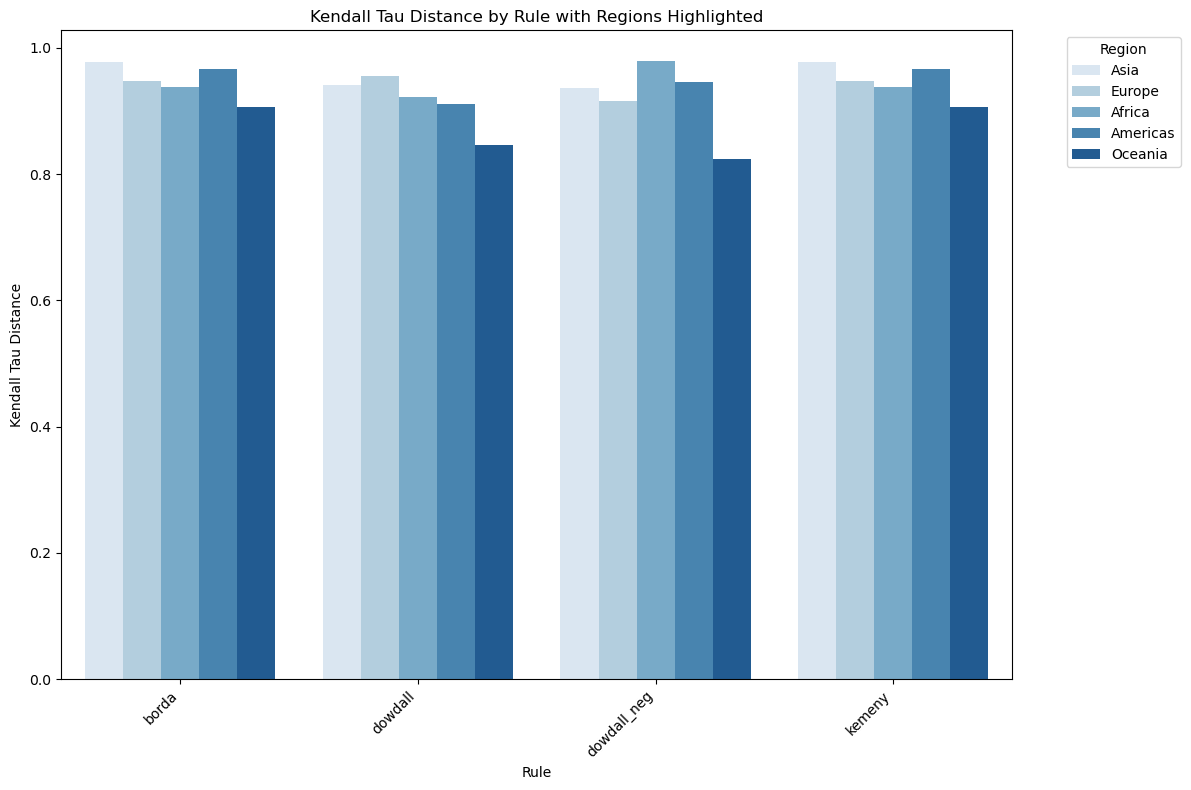

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Убираем столбцы 'a_mean' и 'g_mean'
result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean'])]

# Создаем фигуру и оси графика
plt.figure(figsize=(12, 8))

# Создание столбчатой диаграммы с группировкой по правилу и раскрашиванием по регионам
sns.barplot(x='rule', y='Kendall_tau_distance', hue='region', data=result_df_filtered, palette='Blues')

# Добавление заголовка и меток осей
plt.title('Kendall Tau Distance by Rule with Regions Highlighted')
plt.xlabel('Rule')
plt.ylabel('Kendall Tau Distance')

# Поворот меток оси X для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Отображение легенды справа от графика
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')

# Отображение графика
plt.tight_layout()
plt.show()

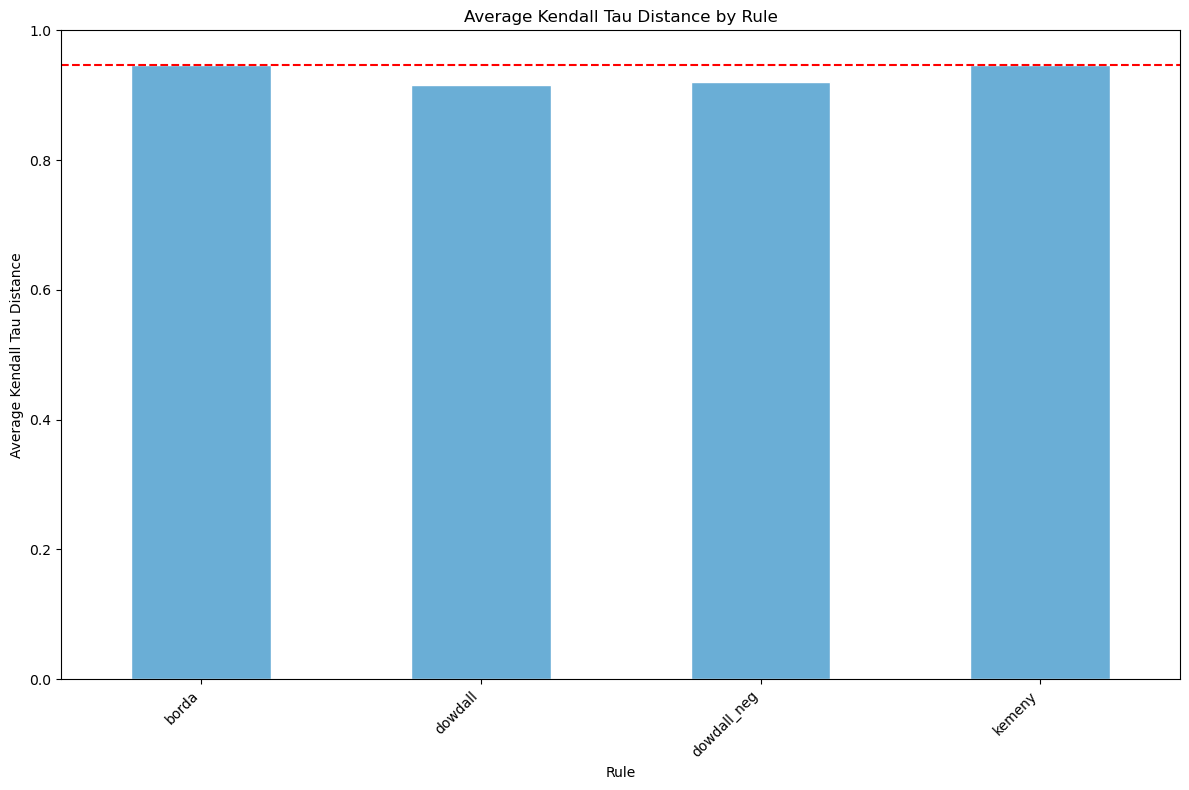

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

# Убираем столбцы 'a_mean' и 'g_mean'
result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean'])]

# Группировка данных по столбцу 'rule' и расчет среднего по столбцу 'Kendall_tau_distance' для каждого правила
mean_by_rule = result_df_filtered.groupby('rule')['Kendall_tau_distance'].mean()

# Получаем самый темный цвет из палитры "Blues"
darkest_blue = sns.color_palette('Blues', n_colors=1, desat=1)[0]

# Создаем фигуру и оси графика
plt.figure(figsize=(12, 8))

# Создание столбчатой диаграммы с заданным цветом
mean_by_rule.plot(kind='bar', color=darkest_blue, edgecolor='white')

# Добавление заголовка и меток осей
plt.title('Average Kendall Tau Distance by Rule')
plt.xlabel('Rule')
plt.ylabel('Average Kendall Tau Distance')

# Установка шкалы по оси Y от 0 до 1
plt.ylim(0, 1)

# Поворот меток оси X для лучшей читаемости
plt.xticks(rotation=45, ha='right')

# Отображение горизонтальной красной черты на уровне самого большого столбика
plt.axhline(y=mean_by_rule.max(), color='red', linestyle='--')

# Отображение графика
plt.tight_layout()
plt.show()

In [22]:
import pandas as pd

# Создание сводной таблицы
pivot_table = result_df.pivot_table(index='rule', columns='region', values='Kendall_tau_distance', aggfunc='mean')

# Округление значений до 5 знаков после запятой
pivot_table = pivot_table.round(5)

print(pivot_table)

region        Africa  Americas     Asia   Europe  Oceania
rule                                                     
a_mean       1.00000   1.00000  1.00000  1.00000  1.00000
borda        0.93841   0.96679  0.97732  0.94743  0.90609
dowdall      0.92275   0.91169  0.94149  0.95587  0.84615
dowdall_neg  0.97868   0.94622  0.93617  0.91638  0.82418
g_mean       1.00000   1.00000  1.00000  1.00000  1.00000
kemeny       0.93841   0.96679  0.97687  0.94743  0.90609


In [ ]:
# Создание пустого словаря для хранения результатов группировки
group_assignments = {}

# Задание значений К от 5 до 100 с шагом 10
for k in range(10, 120, 30):
    # Инициализация списка для хранения групп для текущего значения К
    groups = []
    
    # Перебор стран и присвоение каждой стране группы в зависимости от значения К
    for country_index in range(len(HDI_2022)):
        group_index = country_index // k + 1  # Определение индекса группы для текущей страны
        groups.append(group_index)
    
    # Сохранение группировки в словаре для текущего значения К
    group_assignments[k] = groups

# Вывод результатов
for k, groups in group_assignments.items():
    print(f"Для K = {k}, группы стран выглядят следующим образом:")
    print(groups)
    print()

In [ ]:
# Создаем пустой DataFrame для HDI_2022 с новыми столбцами
HDI_grouped = HDI_2022.copy()

# Добавляем столбцы для каждого значения К
for k, groups in group_assignments.items():
    HDI_grouped[f'k_{k}'] = groups
    
# Добавляем столбцы для каждого значения К
for k, groups in group_assignments.items():
    rank_rules[f'k_{k}'] = groups

print(rank_rules)

In [ ]:
unique_columns = rank_rules.drop(columns=['g_mean', 'a_mean', 'borda', 'dowdall', 'dowdall_neg', 'country', 'region']).columns.unique()
    
for column in unique_columns:
    unique_groups = rank_rules[column].unique()
    print(unique_groups)

In [ ]:
# Получение уникальных значений групп к странам из rank_rules
unique_columns = rank_rules.drop(columns=['g_mean', 'a_mean', 'borda', 'dowdall', 'dowdall_neg', 'country', 'region']).columns.unique()
unique_columns

In [ ]:
rank_rules_group = rank_rules.iloc[:, 0:5].rank(axis=0, method='min', ascending=True)
rank_rules

In [ ]:
rank_rules

In [ ]:
HDI_grouped

In [83]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau

def calculate_kendall_tau_distance_for_groups(rank_rules, HDI_grouped):
    # Создание пустого DataFrame для хранения результатов
    distances_df = pd.DataFrame(columns=['k', 'rule', 'Kendall_tau_distance'])
    
    # Получение уникальных значений групп к странам из rank_rules
    exclude_columns = ['g_mean', 'a_mean', 'borda', 'dowdall', 'dowdall_neg', 'country', 'region', 'plurality', 'antiplurality', 'product_ranks', 'product_ranks_inverse']
    unique_columns = list(set(rank_rules.columns) - set(exclude_columns))
    
    for column in unique_columns:
        unique_groups = rank_rules[column].unique()
        for group in unique_groups:
            rank_rules_group = rank_rules[rank_rules[column] == group]
            HDI_group = HDI_grouped[HDI_grouped[column] == group]
            
            # Расчет rank для текущего региона
            rank_rules_group = rank_rules_group.iloc[:, :9].rank(axis=0, method='min', ascending=True)
            
            # Формирование DataFrame для HDI данных
            HDI_forscore_group = pd.DataFrame()
            HDI_forscore_group['HI'] = HDI_group['HI']
            HDI_forscore_group['EI'] = HDI_group['EI']
            HDI_forscore_group['II'] = HDI_group['II']
            
            # Расчет различных показателей
            rules_HDI_group = pd.DataFrame()
            rules_HDI_group['g_mean'] = np.power(np.prod(HDI_forscore_group, axis=1), 1 / HDI_forscore_group.shape[1])
            rules_HDI_group['a_mean'] = HDI_forscore_group.mean(axis=1)
            rules_HDI_group['borda'] = calculate_borda_scores(HDI_forscore_group, type='original')
            rules_HDI_group['dowdall'] = calculate_borda_scores(HDI_forscore_group, type='dowdall')
            rules_HDI_group['dowdall_neg'] = calculate_borda_scores(HDI_forscore_group, type='dowdall_neg')
            
            # Ранжирование данных для текущего региона
            ranks_group = rules_HDI_group.rank(axis=0, method='min', ascending=False)
            ranks_group['plurality'] = plurality(HDI_forscore_group)
            ranks_group['antiplurality'] = antiplurality(HDI_forscore_group)
            ranks_group['product_ranks'] = product_rank(HDI_forscore_group)
            ranks_group['product_ranks_inverse'] = product_rank_inverse(HDI_forscore_group)
            
            # Словарь для хранения результатов
            distances = {}
            for col in rank_rules_group.columns:
                distance, _ = kendalltau(rank_rules_group[col], ranks_group[col])
                distances[col] = distance
        
            # Создание DataFrame из словаря с результатами для текущей группы
            distances_group_df = pd.DataFrame(list(distances.items()), columns=['rule', 'Kendall_tau_distance'])
            distances_group_df['k'] = group
            distances_group_df['column'] = column
          
            # Объединение результатов с общим DataFrame
            distances_df = pd.concat([distances_df, distances_group_df], ignore_index=True)
    
    return distances_df

# Пример использования функции
#result_df = calculate_kendall_tau_distance_for_groups(rank_rules, HDI_grouped)
#print(result_df)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Убираем столбцы 'a_mean' и 'g_mean'
result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean'])]

# Группировка данных по значению 'column' для построения отдельных графиков
grouped_df = result_df_filtered.groupby('column')

# Создаем фигуру с 2x2 подграфиками
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Проходим по каждому уникальному значению столбца 'column'
for (column, data), ax in zip(grouped_df, axes.flatten()):
    sns.barplot(x='rule', y='Kendall_tau_distance', hue='k', data=data, palette='Blues', edgecolor='white', ax=ax)
    ax.set_title(f'Kendall Tau Correlation for {column}')
    ax.set_xlabel('Rule')
    ax.set_ylabel('Kendall Tau Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.legend(title='k', bbox_to_anchor=(1.05, 1), loc='upper left')

# Убираем пустой subplot, если количество уникальных значений столбца 'column' не равно 4
if len(grouped_df) < 4:
    for ax in axes.flatten()[len(grouped_df):]:
        ax.remove()

# Корректируем расположение подписей и сохраняем график
plt.tight_layout()
plt.savefig('kendall_tau_distances_groups_4.png', bbox_inches='tight')
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Убираем столбцы 'a_mean' и 'g_mean'
result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean'])]

# Группировка данных по значению 'column' для построения отдельных графиков
grouped_df = result_df_filtered.groupby('column')

# Создаем фигуру с 2x2 подграфиками
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Проходим по каждому уникальному значению столбца 'column'
for (column, data), ax in zip(grouped_df, axes.flatten()):
    # Усреднение по столбцу 'Kendall_tau_distance' для каждого правила
    mean_by_rule = data.groupby('rule')['Kendall_tau_distance'].mean()
    sns.barplot(x=mean_by_rule.index, y=mean_by_rule.values, palette='Blues', edgecolor='white', ax=ax)
    ax.set_title(f'Average Kendall Tau Correlation for {column}')
    ax.set_xlabel('Rule')
    ax.set_ylabel('Average Kendall Tau Correlation')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Находим максимальное значение среди усредненных Kendall Tau Distance
    max_value = mean_by_rule.max()
    # Рисуем красную линию на уровне максимального значения
    ax.axhline(y=max_value, color='red', linestyle='--', label=f'Max Value: {max_value}')
    # Добавляем легенду
    ax.legend()

# Убираем пустой subplot, если количество уникальных значений столбца 'column' не равно 4
if len(grouped_df) < 4:
    for ax in axes.flatten()[len(grouped_df):]:
        ax.remove()

# Корректируем расположение подписей и сохраняем график
plt.tight_layout()
plt.savefig('kendall_tau_distances_combined.png', bbox_inches='tight')
plt.show()

In [ ]:
# Группировка данных по стране и количеству k для расчета средних значений Kendall Tau
grouped_means = result_df.groupby(['Country', 'k'])['Kendall_tau_distance'].mean().reset_index()

# Округление средних значений Kendall Tau до 5 знаков после запятой
grouped_means['Kendall_tau_distance'] = grouped_means['Kendall_tau_distance'].round(5)

# Вывод таблицы средних значений Kendall Tau
print(grouped_means)

In [31]:
# Список всех годов в датасете
data = pd.read_csv('HDR23-24.csv', encoding='latin-1')
years = [col for col in data.columns if col.startswith('hdi_')]

# Создание пустого DataFrame для хранения результатов
result_df = pd.DataFrame()

# Перебор всех годов и выполнение операций для каждого года
for year in range(1990, 2023):
    hdi_year = pd.DataFrame()
    hdi_year[['iso3', 'region', f'le_{year}', f'eys_{year}', f'mys_{year}', f'gnipc_{year}']] = data[['iso3', 'region', f'le_{year}', f'eys_{year}', f'mys_{year}', f'gnipc_{year}']]
    
    # Нормировка
    hdi_year[f'HI_{year}'] = (hdi_year[f'le_{year}'] - 20) / (85 - 20)
    hdi_year[f'EI_{year}'] = (hdi_year[f'eys_{year}'] / 18 + hdi_year[f'mys_{year}'] / 15) / 2
    hdi_year[f'II_{year}'] = (np.log(hdi_year[f'gnipc_{year}']) - np.log(100)) / (np.log(75000) - np.log(100))
    
    # Добавление данных за текущий год в общий DataFrame
    hdi_all = pd.DataFrame()
    hdi_all[[f'HI_{year}', f'EI_{year}', f'II_{year}']] = hdi_year[[ f'HI_{year}', f'EI_{year}', f'II_{year}']]
    result_df = pd.concat([result_df, hdi_all], sort = False, axis = 1)

result_df['iso3'] = data['iso3']
hdi_all = pd.merge(result_df, regions, left_on='iso3', right_on='alpha-3', how='left').iloc[:, list(range(0, 100)) + [105]]
hdi_all

HI_1990   EI_1990   II_1990   HI_1991   EI_1991   II_1991   HI_1992  \
0    0.399492  0.110634  0.519485  0.410200  0.120188  0.504279  0.424554   
1    0.817600  0.566803  0.589847  0.821200  0.572350  0.537130  0.826385   
2    0.729477  0.425984  0.672728  0.733662  0.433898  0.665243  0.734723   
3    0.898554       NaN  0.921289  0.892015       NaN  0.919917  0.928062   
4    0.336815       NaN  0.595295  0.366354       NaN  0.611840  0.341677   
..        ...       ...       ...       ...       ...       ...       ...   
201  0.735106  0.551226  0.720338  0.732453  0.554734  0.709175  0.721478   
202  0.734934  0.502416  0.700421  0.740422  0.507157  0.703765  0.745522   
203  0.597398  0.308446  0.473961  0.601575  0.313613  0.476319  0.611193   
204  0.459518  0.285940  0.502741  0.461371  0.293496  0.499849  0.460006   
205  0.694536  0.453102  0.690695  0.696911  0.457584  0.689847  0.701290   

      EI_1992   II_1992   HI_1993  ...   EI_2020   II_2020   HI_2021  \
0    0.129743  0.484692  0.484092  ...  0.392092  0.451523  0.645877   
1    0.541085  0.522436  0.829831  ...  0.747364  0.736070  0.868662   
2    0.443457  0.665813  0.734138  ...  0.657976  0.704936  0.867338   
3         NaN  0.916358  0.902508  ...  0.706253  0.932669  0.928738   
4         NaN  0.467161  0.340015  ...  0.532799  0.604992  0.640662   
..        ...       ...       ...  ...       ...       ...       ...   
201  0.555069  0.697065  0.718744  ...  0.780718  0.784734  0.813175   
202  0.512345  0.705851  0.750567  ...  0.709138  0.744822  0.801537   
203  0.318543  0.480645  0.616284  ...  0.533369  0.624350  0.736241   
204  0.299716  0.490092  0.458725  ...  0.482724  0.540057  0.617115   
205  0.462360  0.689621  0.703900  ...  0.646787  0.766784  0.790239   

      EI_2021   II_2021   HI_2022   EI_2022   II_2022       iso3  region  
0    0.396874  0.412466  0.659677  0.381198  0.391487        AFG    Asia  
1    0.742142  0.750716  0.874354  0.739801  0.759811        ALB  Europe  
2    0.660555  0.707586  0.878908  0.663134  0.709738        DZA  Africa  
3    0.714232  0.942123  0.977723  0.742220  0.951029        AND  Europe  
4    0.532799  0.600671  0.645062  0.532799  0.600525        AGO  Africa  
..        ...       ...       ...       ...       ...        ...     ...  
201  0.783931  0.794292  0.824070  0.784346  0.798540    ZZG.ECA     NaN  
202  0.709898  0.753286  0.826386  0.709590  0.757983    ZZH.LAC     NaN  
203  0.539612  0.633754  0.745255  0.550838  0.641146     ZZI.SA     NaN  
204  0.486698  0.541798  0.625226  0.485810  0.544064    ZZJ.SSA     NaN  
205  0.648071  0.774344  0.800063  0.649547  0.778036  ZZK.WORLD     NaN  

[206 rows x 101 columns]

In [181]:
from scipy.stats import kendalltau

def calculate_indices_for_years(data):
    # Создание пустого DataFrame для хранения результатов
    result_df = pd.DataFrame(columns=['rule', 'Kendall_tau_distance', 'region', 'year'])

    # Перебор всех годов и выполнение операций для каждого года
    for year in range(1990, 2023):
        HDI_year = pd.DataFrame()

        # Получение данных для текущего года
        HDI_year[['HI', 'EI', 'II', 'region']] = data[['HI_{}'.format(year), 'EI_{}'.format(year), 'II_{}'.format(year), 'region']]
        
        # Удаление строк с отсутствующими значениями
        HDI_year = HDI_year.dropna()

        # Создание DataFrame с данными для расчета индексов
        HDI_forscore = HDI_year[['HI', 'EI', 'II']]

        # Создание DataFrame для хранения правил
        rules_HDI = pd.DataFrame()
        rules_HDI['g_mean'] = np.power(np.prod(HDI_forscore, axis=1), 1 / HDI_forscore.shape[1])
        rules_HDI['a_mean'] = HDI_forscore.mean(axis=1)
        rules_HDI['borda'] = calculate_borda_scores(HDI_forscore, type='original')
        rules_HDI['dowdall'] = calculate_borda_scores(HDI_forscore, type='dowdall')
        rules_HDI['dowdall_neg'] = calculate_borda_scores(HDI_forscore, type='dowdall_neg')
        
        rank_rules = rules_HDI.rank(axis=0, method='min', ascending=False)
        rank_rules['plurality'] = plurality(HDI_forscore)
        rank_rules['antiplurality'] = antiplurality(HDI_forscore)
        rank_rules['product_ranks'] = product_rank(HDI_forscore)
        rank_rules['product_ranks_inverse'] = product_rank_inverse(HDI_forscore)
        rank_rules['region'] = HDI_year['region']
        rank_components = HDI_forscore.rank(axis=0, method='min', ascending=False)

        # Расчет расстояния Кендалла для каждого региона
        
        distances_df = calculate_kendall_tau_distance_for_regions(rank_rules, HDI_year)
        # Добавление информации о годе в DataFrame с результатами
        distances_df['year'] = year
        
        # Объединение результатов с общим DataFrame
        result_df = pd.concat([result_df, distances_df], ignore_index=True)
        


    return result_df

# Пример использования функции
result_df = calculate_indices_for_years(hdi_all)
print(result_df)

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\1653639862.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distances_df = pd.concat([distances_df, distances_region_df], ignore_index=True)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2969617951.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, distances_df], ignore_index=True)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\1653639862.py:54: FutureWarning: The behavior of DataFrame concatenation 

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\1653639862.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distances_df = pd.concat([distances_df, distances_region_df], ignore_index=True)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\1653639862.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distances_df = pd.concat([distances_df, distances_region_df], ignore_index=True)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\1653639862.py:54: FutureWarning: The behavior of DataFrame c

                       rule  Kendall_tau_distance   region  year
0                    g_mean              1.000000     Asia  1990
1                    a_mean              1.000000     Asia  1990
2                     borda              0.962701     Asia  1990
3                   dowdall              0.914651     Asia  1990
4               dowdall_neg              0.960171     Asia  1990
...                     ...                   ...      ...   ...
1480            dowdall_neg              0.824176  Oceania  2022
1481              plurality              0.890110  Oceania  2022
1482          antiplurality              0.890110  Oceania  2022
1483          product_ranks              0.802198  Oceania  2022
1484  product_ranks_inverse              0.883991  Oceania  2022

[1485 rows x 4 columns]


C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\1653639862.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distances_df = pd.concat([distances_df, distances_region_df], ignore_index=True)


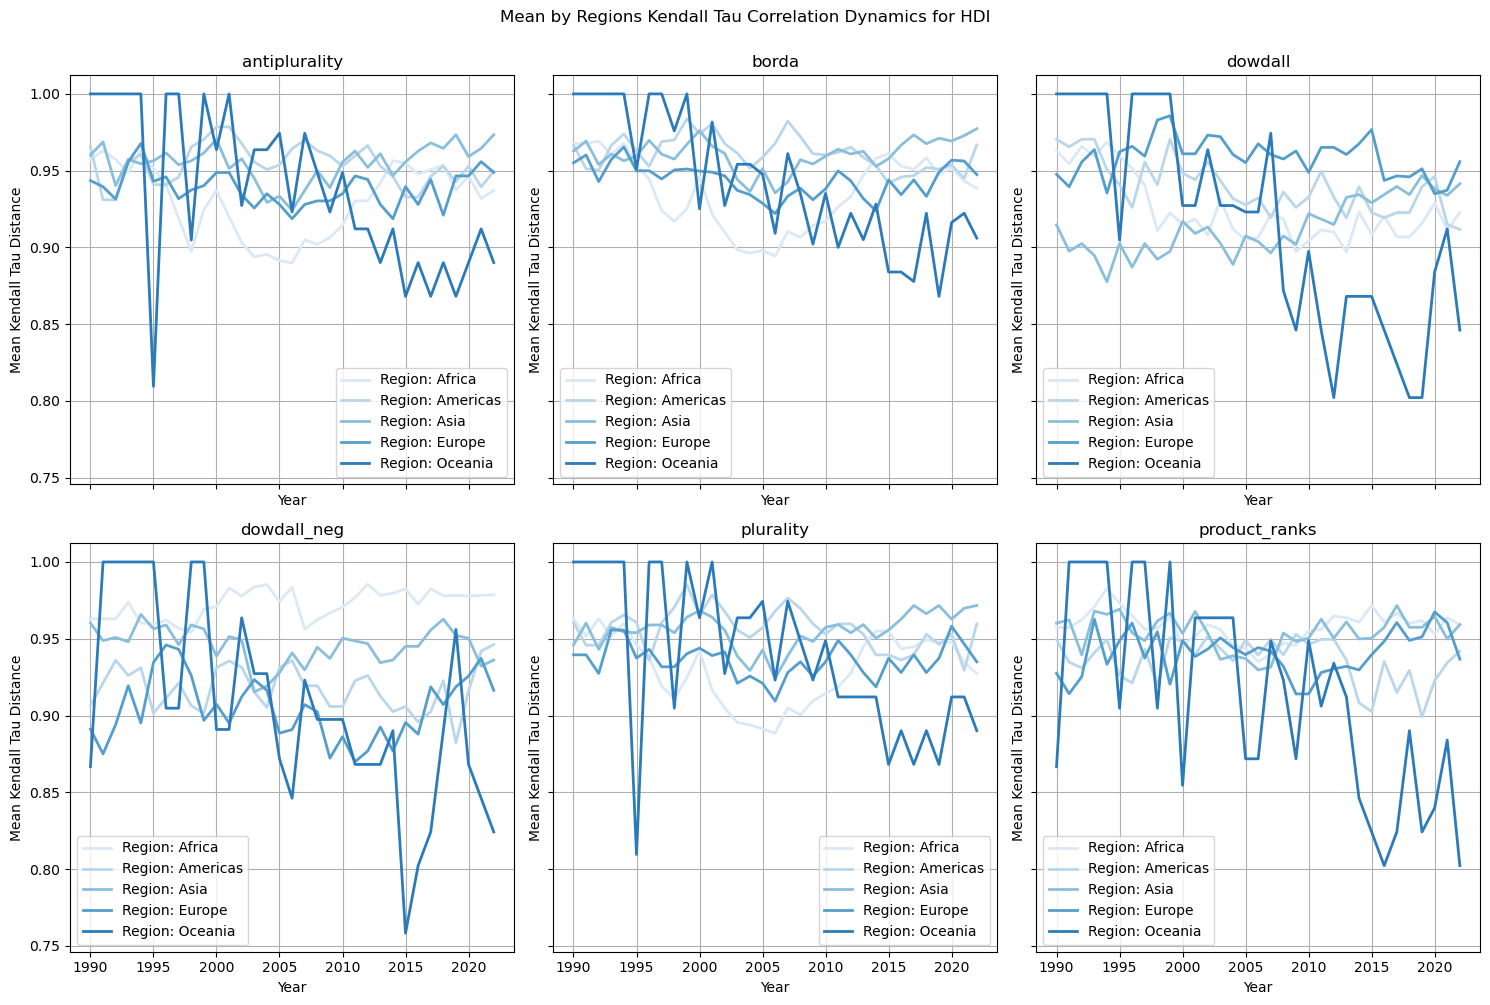

In [198]:
import pandas as pd
import matplotlib.pyplot as plt

# Filter out the excluded rules
result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

# Group data by rule, region, and year, then calculate the mean Kendall Tau Correlation for each group
mean_kendall_tau_region_df = result_df_filtered.groupby(['rule', 'region', 'year']).mean().reset_index()

# Get unique rules from the filtered DataFrame
rules = mean_kendall_tau_region_df['rule'].unique()

# Create subplots with shared x-axis and y-axis
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Plotting graphs for each rule
for i, rule in enumerate(rules):
    ax = axs[i // 3, i % 3]  # Calculate subplot index
    
    for region in mean_kendall_tau_region_df['region'].unique():
        # Filter data for the current rule and region
        rule_region_df = mean_kendall_tau_region_df[(mean_kendall_tau_region_df['rule'] == rule) & (mean_kendall_tau_region_df['region'] == region)]
        
        # Group by year and calculate the mean Kendall Tau Correlation for each year
        mean_kendall_tau_year = rule_region_df.groupby('year')['Kendall_tau_distance'].mean()
        
        # Plot Kendall Tau Distance dynamics
        ax.plot(mean_kendall_tau_year.index, mean_kendall_tau_year.values, linestyle='-', linewidth=2, label=f'Region: {region}')
    
    # Set plot title and labels
    ax.set_title(f'{rule}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean Kendall Tau Distance')
    ax.grid(True)
    ax.legend()

# Set common title for all subplots
plt.suptitle('Mean by Regions Kendall Tau Correlation Dynamics for HDI', y=1)

# Adjust layout
plt.tight_layout()
plt.savefig('kendall_tau_dynamics_rules_regions_HDI.pdf', dpi=1000)
plt.show()

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\1173871159.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a fut

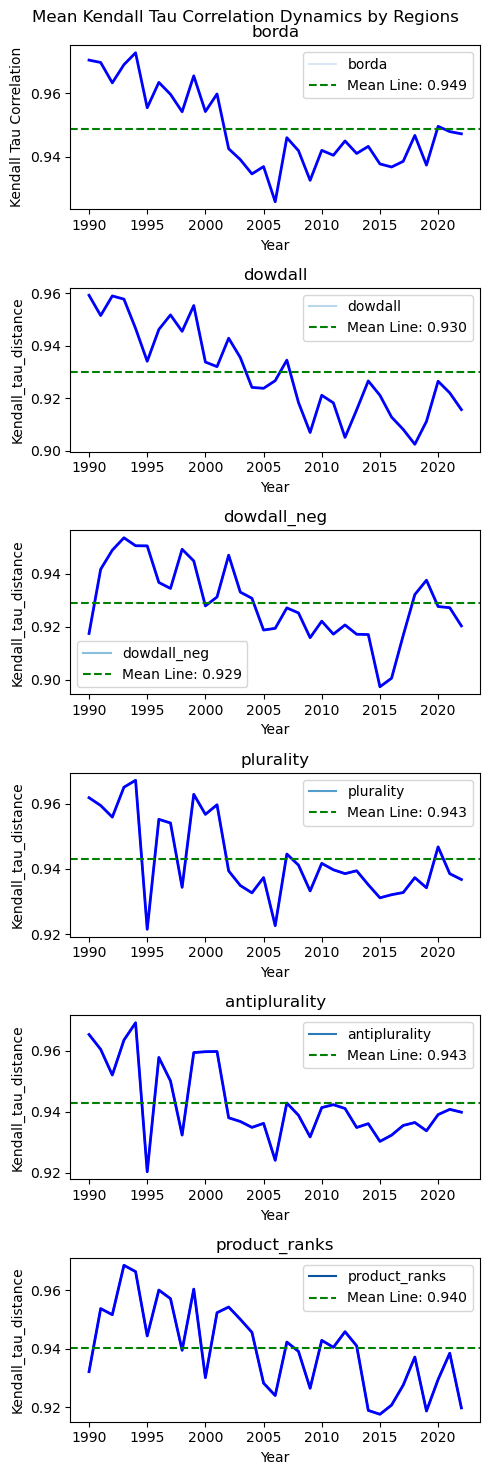

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kendall_tau_dynamics_by_rule(result_df):
    # Убираем столбцы 'a_mean' и 'g_mean'
    result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

    # Определение уникальных правил
    unique_rules = result_df_filtered['rule'].unique()

    # Создание трех графиков в одном ряду
    fig, axes = plt.subplots(nrows=len(unique_rules), ncols=1, figsize=(5, 15), constrained_layout=True)

    # Цвета для графиков
    palette = sns.color_palette('Blues', n_colors=len(unique_rules))

    # Перебор по правилам и построение графиков
    for i, rule in enumerate(unique_rules):
        data_rule = result_df_filtered[result_df_filtered['rule'] == rule]
        data_rule = data_rule.sort_values(by='year')

        # Построение графика для текущего правила
        sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)

        # Добавление заголовка для текущего графика
        axes[i].set_title(rule)

        # Установка меток оси X
        axes[i].set_xlabel('Year')

        # Установка меток оси Y только на левом графике
        if i == 0:
            axes[i].set_ylabel('Kendall Tau Correlation')

        # Включение легенды только на последнем графике
        if i < len(unique_rules) - 1:
            axes[i].get_legend().remove()
        else:
            axes[i].legend(title='Rule')

        # Вычисление среднего значения для текущего правила
        mean_values = data_rule.groupby('year')['Kendall_tau_distance'].mean()
        axes[i].plot(mean_values.index, mean_values.values, color='blue', linewidth=2)

        # Добавление прямой на уровне среднего по годам
        mean_line = mean_values.mean()
        axes[i].axhline(y=mean_line, color='green', linestyle='--', label=f'Mean Line: {mean_line:.3f}')
        axes[i].legend()
        
    # Установка общего заголовка для всех графиков
    plt.suptitle('Mean Kendall Tau Correlation Dynamics by Regions')

    # Отображение графиков
    plt.tight_layout()
    plt.savefig('kendall_tau_dynamics_regions.png', dpi=1000)
    plt.show()

# Пример использования функции
plot_kendall_tau_dynamics_by_rule(result_df)

In [180]:
result_df

k                   rule  Kendall_tau_distance column  year
0     1                 g_mean              1.000000   k_40  1990
1     1                 a_mean              1.000000   k_40  1990
2     1                  borda              0.974228   k_40  1990
3     1                dowdall              0.966667   k_40  1990
4     1            dowdall_neg              0.956410   k_40  1990
...  ..                    ...                   ...    ...   ...
7159  3            dowdall_neg              1.000000  k_100  2022
7160  3              plurality              1.000000  k_100  2022
7161  3          antiplurality              1.000000  k_100  2022
7162  3          product_ranks              1.000000  k_100  2022
7163  3  product_ranks_inverse              1.000000  k_100  2022

[7164 rows x 5 columns]

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2764596444.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a fut

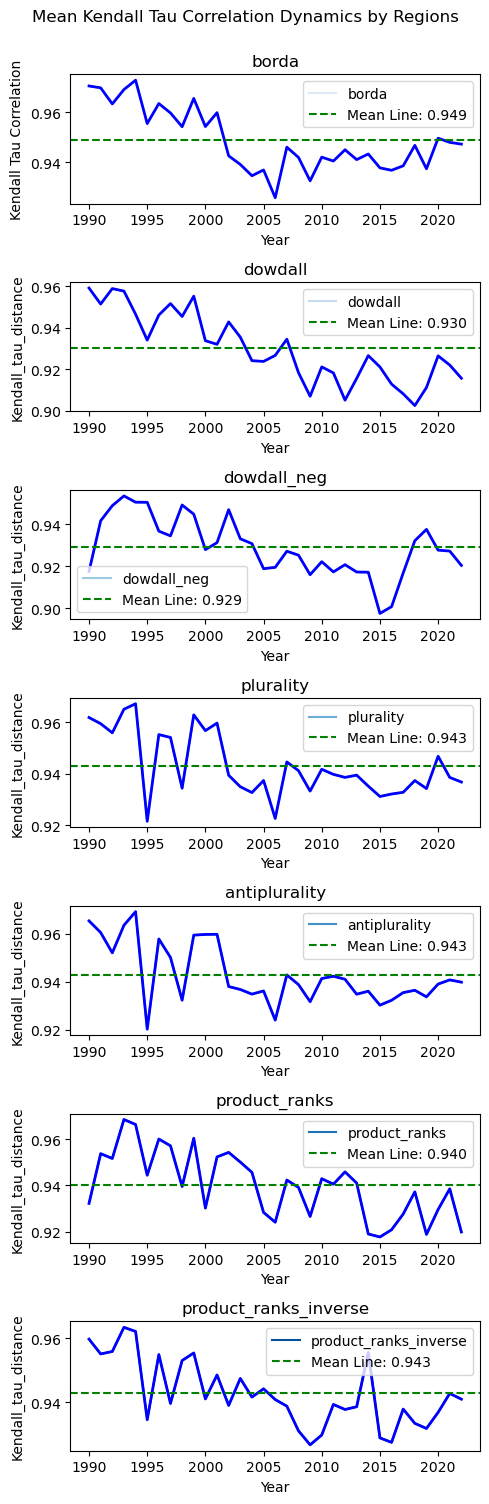

In [58]:
def plot_kendall_tau_dynamics_by_rule(result_df):
    # Убираем столбцы 'a_mean' и 'g_mean'
    result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean'])]

    # Определение уникальных правил
    unique_rules = result_df_filtered['rule'].unique()

    # Создание трех графиков в одном ряду
    fig, axes = plt.subplots(nrows=len(unique_rules), ncols=1, figsize=(5, 15), constrained_layout=True)

    # Цвета для графиков
    palette = sns.color_palette('Blues', n_colors=len(unique_rules))

    # Перебор по правилам и построение графиков
    for i, rule in enumerate(unique_rules):
        data_rule = result_df_filtered[result_df_filtered['rule'] == rule]
        data_rule = data_rule.sort_values(by='year')

        # Построение графика для текущего правила
        sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)

        # Добавление заголовка для текущего графика
        axes[i].set_title(rule)

        # Установка меток оси X
        axes[i].set_xlabel('Year')

        # Установка меток оси Y только на левом графике
        if i == 0:
            axes[i].set_ylabel('Kendall Tau Correlation')

        # Включение легенды только на последнем графике
        if i < len(unique_rules) - 1:
            axes[i].get_legend().remove()
        else:
            axes[i].legend(title='Rule')

        # Вычисление среднего значения для текущего правила
        mean_values = data_rule.groupby('year')['Kendall_tau_distance'].mean()
        axes[i].plot(mean_values.index, mean_values.values, color='blue', linewidth=2)

        # Добавление прямой на уровне среднего по годам
        mean_line = mean_values.mean()
        axes[i].axhline(y=mean_line, color='green', linestyle='--', label=f'Mean Line: {mean_line:.3f}')
        axes[i].legend()
        
    # Установка общего заголовка для всех графиков
    plt.suptitle('Mean Kendall Tau Correlation Dynamics by Regions', y=1)  # Поднимаем заголовок на 5%

    # Отображение графиков
    plt.tight_layout()
    plt.savefig('kendall_tau_dynamics_regions.png', dpi=1000)
    plt.show()

# Пример использования функции
plot_kendall_tau_dynamics_by_rule(result_df)

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2357575825.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a fut

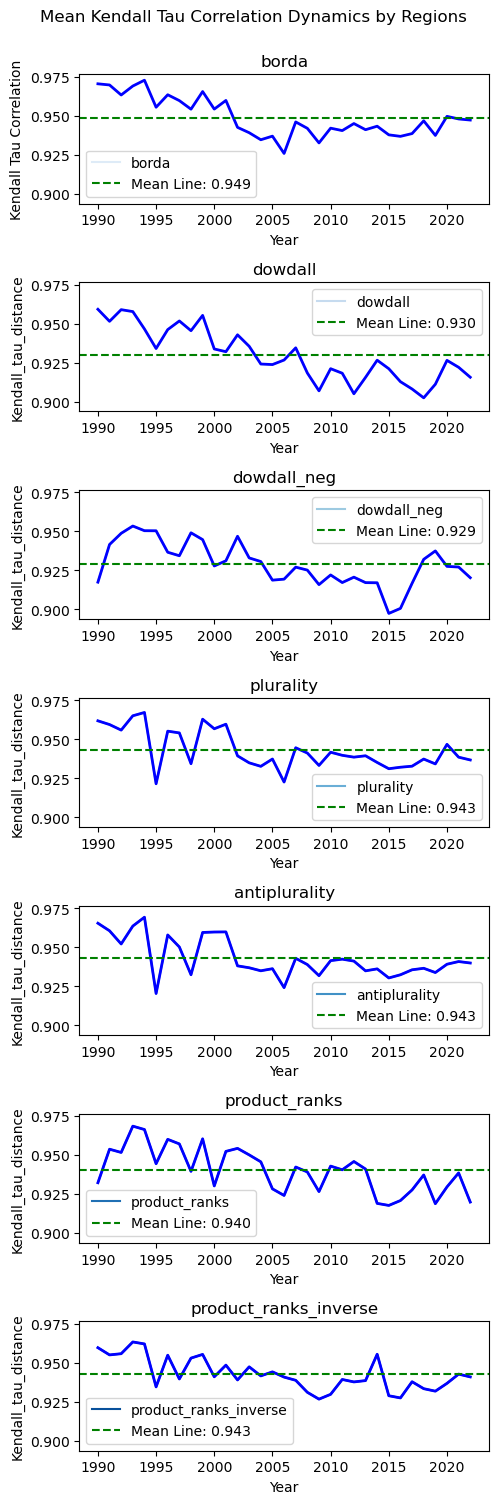

In [59]:
def plot_kendall_tau_dynamics_by_rule(result_df):
    # Убираем столбцы 'a_mean' и 'g_mean'
    result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

    # Определение уникальных правил
    unique_rules = result_df_filtered['rule'].unique()

    # Создание трех графиков в одном ряду
    fig, axes = plt.subplots(nrows=len(unique_rules), ncols=1, figsize=(5, 15), constrained_layout=True, sharey=True)

    # Цвета для графиков
    palette = sns.color_palette('Blues', n_colors=len(unique_rules))

    # Перебор по правилам и построение графиков
    for i, rule in enumerate(unique_rules):
        data_rule = result_df_filtered[result_df_filtered['rule'] == rule]
        data_rule = data_rule.sort_values(by='year')

        # Построение графика для текущего правила
        sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)

        # Добавление заголовка для текущего графика
        axes[i].set_title(rule)

        # Установка меток оси X
        axes[i].set_xlabel('Year')

        # Установка меток оси Y только на левом графике
        if i == 0:
            axes[i].set_ylabel('Kendall Tau Correlation')

        # Включение легенды только на последнем графике
        if i < len(unique_rules) - 1:
            axes[i].get_legend().remove()
        else:
            axes[i].legend(title='Rule')

        # Вычисление среднего значения для текущего правила
        mean_values = data_rule.groupby('year')['Kendall_tau_distance'].mean()
        axes[i].plot(mean_values.index, mean_values.values, color='blue', linewidth=2)

        # Добавление прямой на уровне среднего по годам
        mean_line = mean_values.mean()
        axes[i].axhline(y=mean_line, color='green', linestyle='--', label=f'Mean Line: {mean_line:.3f}')
        axes[i].legend()
        
    # Установка общего заголовка для всех графиков
    plt.suptitle('Mean Kendall Tau Correlation Dynamics by Regions', y=1)  # Поднимаем заголовок на 5%

    # Отображение графиков
    plt.tight_layout()
    plt.savefig('kendall_tau_dynamics_regions.png', dpi=1000)
    plt.show()

# Пример использования функции
plot_kendall_tau_dynamics_by_rule(result_df)


C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\66149607.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a futur

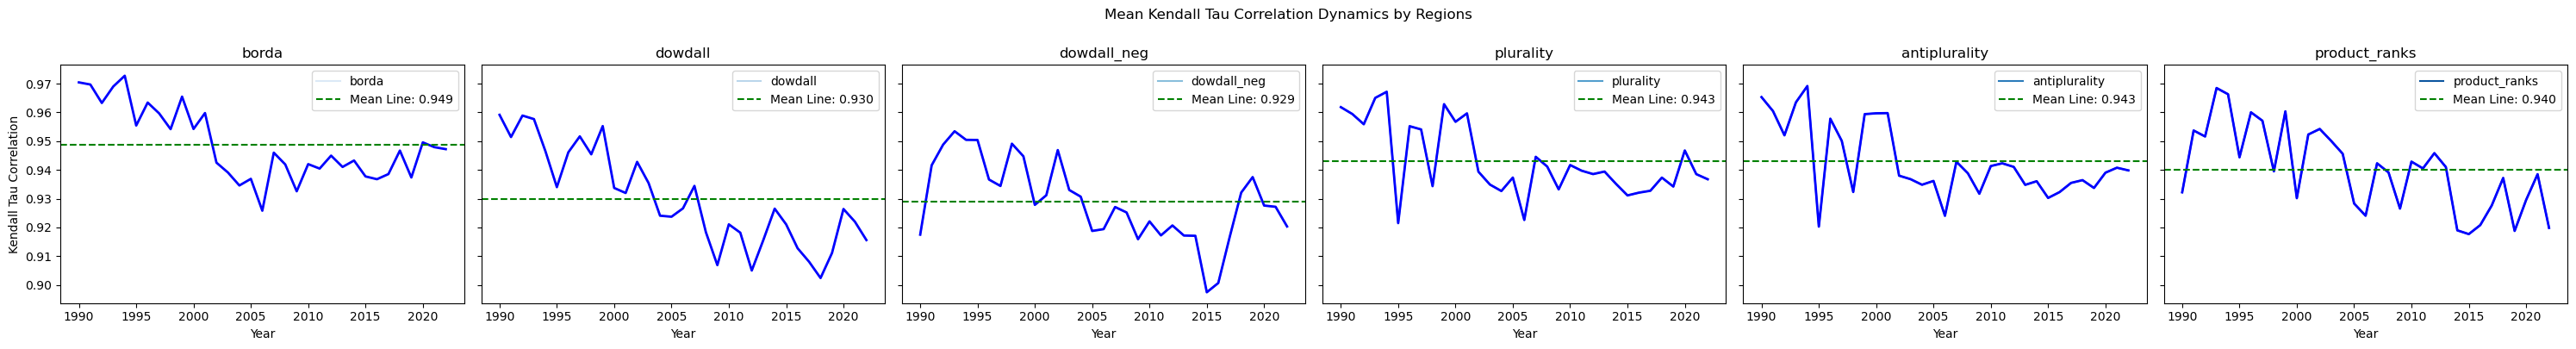

In [71]:
def plot_kendall_tau_dynamics_by_rule(result_df):
    # Убираем столбцы 'a_mean' и 'g_mean'
    result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

    # Определение уникальных правил
    unique_rules = result_df_filtered['rule'].unique()

    # Создание трех графиков в одном ряду
    fig, axes = plt.subplots(nrows=1, ncols=len(unique_rules), figsize=(30, 4), constrained_layout=True, sharey=True)

    # Цвета для графиков
    palette = sns.color_palette('Blues', n_colors=len(unique_rules))

    # Перебор по правилам и построение графиков
    for i, rule in enumerate(unique_rules):
        data_rule = result_df_filtered[result_df_filtered['rule'] == rule]
        data_rule = data_rule.sort_values(by='year')

        # Построение графика для текущего правила
        sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)

        # Добавление заголовка для текущего графика
        axes[i].set_title(rule)

        # Установка меток оси X
        axes[i].set_xlabel('Year')

        # Установка меток оси Y только на левом графике
        if i == 0:
            axes[i].set_ylabel('Kendall Tau Correlation')

        # Включение легенды только на последнем графике
        if i < len(unique_rules) - 1:
            axes[i].get_legend().remove()
        else:
            axes[i].legend(title='Rule')

        # Вычисление среднего значения для текущего правила
        mean_values = data_rule.groupby('year')['Kendall_tau_distance'].mean()
        axes[i].plot(mean_values.index, mean_values.values, color='blue', linewidth=2)

        # Добавление прямой на уровне среднего по годам
        mean_line = mean_values.mean()
        axes[i].axhline(y=mean_line, color='green', linestyle='--', label=f'Mean Line: {mean_line:.3f}')
        axes[i].legend()
        
    # Установка общего заголовка для всех графиков
    plt.suptitle('Mean Kendall Tau Correlation Dynamics by Regions', y=1)  # Поднимаем заголовок на 5%

    # Отображение графиков
    plt.tight_layout()
    plt.savefig('kendall_tau_dynamics_regions.png', dpi=1000)
    plt.show()

# Пример использования функции
plot_kendall_tau_dynamics_by_rule(result_df)

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2383110290.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[row, col], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group i

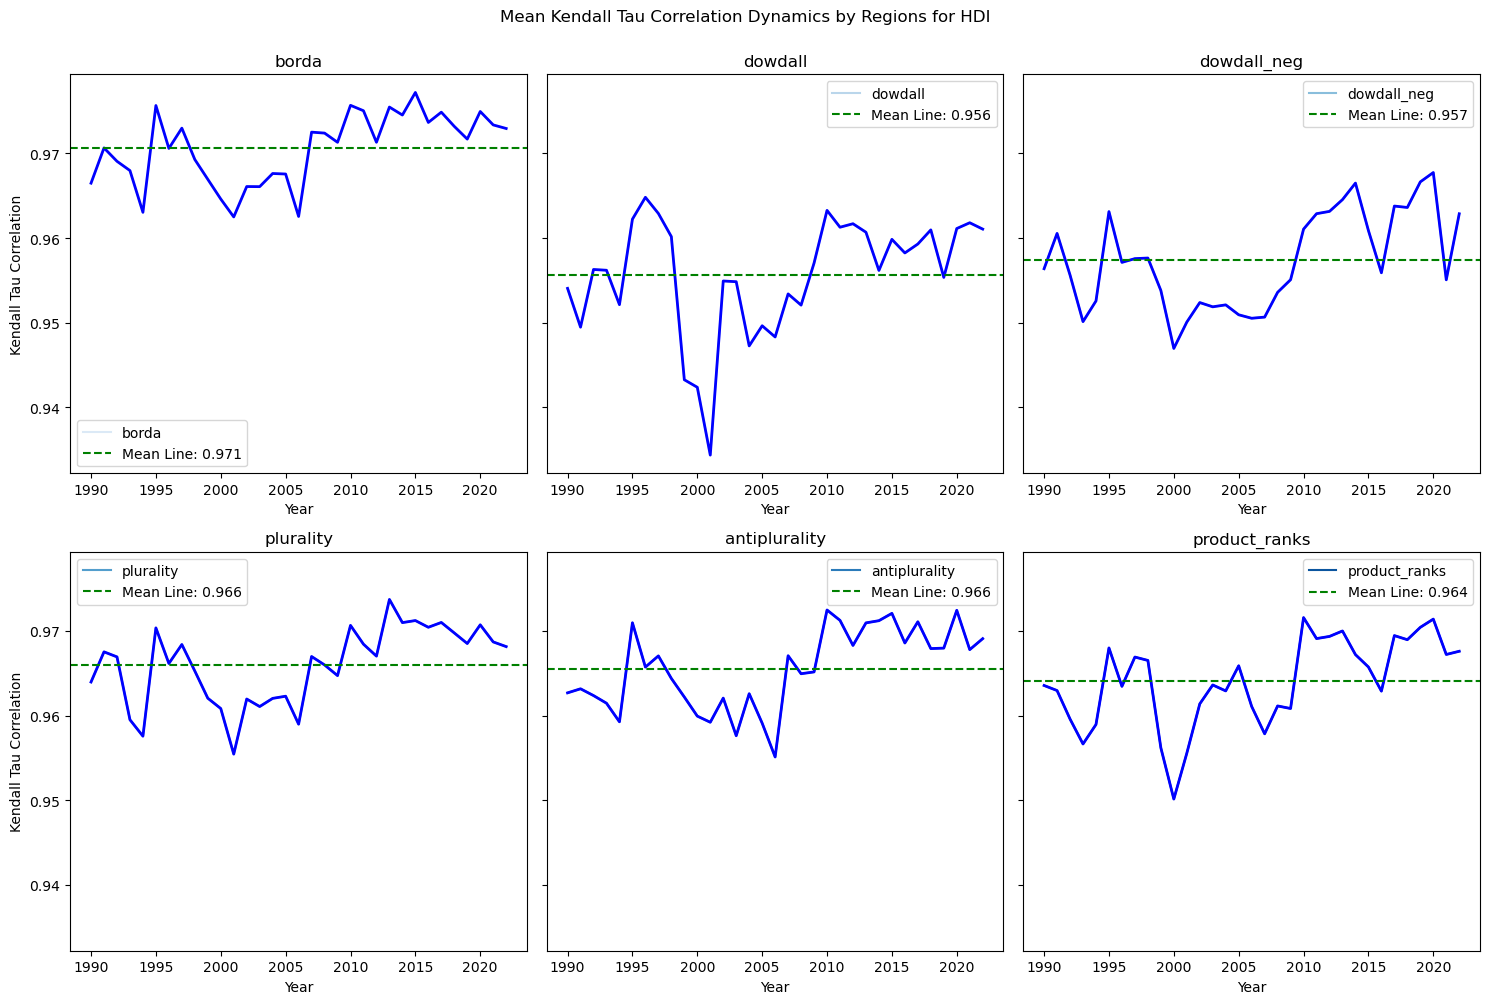

In [112]:
def plot_kendall_tau_dynamics_by_rule(result_df):
    # Убираем столбцы 'a_mean' и 'g_mean'
    result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

    # Определение уникальных правил
    unique_rules = result_df_filtered['rule'].unique()

    # Определение числа строк и столбцов для размещения графиков
    num_plots = len(unique_rules)
    num_rows = (num_plots + 1) // 3  # Округляем вверх до ближайшего целого
    num_cols = 3

    # Создание подграфиков
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10), constrained_layout=True, sharey=True)

    # Цвета для графиков
    palette = sns.color_palette('Blues', n_colors=len(unique_rules))

    # Перебор по правилам и построение графиков
    for i, rule in enumerate(unique_rules):
        row = i // num_cols
        col = i % num_cols

        data_rule = result_df_filtered[result_df_filtered['rule'] == rule]
        data_rule = data_rule.sort_values(by='year')

        # Построение графика для текущего правила
        sns.lineplot(ax=axes[row, col], x='year', y='Kendall_tau_distance', hue='rule', data=data_rule, palette=[palette[i]], ci=None)

        # Добавление заголовка для текущего графика
        axes[row, col].set_title(rule)

        # Установка меток оси X
        axes[row, col].set_xlabel('Year')

        # Установка меток оси Y только на левом графике каждой строки
        if col == 0:
            axes[row, col].set_ylabel('Kendall Tau Correlation')

        # Включение легенды только на последнем графике каждой строки
        if i % num_cols == num_cols - 1 or i == num_plots - 1:
            axes[row, col].legend(title='Rule')

        # Вычисление среднего значения для текущего правила
        mean_values = data_rule.groupby('year')['Kendall_tau_distance'].mean()
        axes[row, col].plot(mean_values.index, mean_values.values, color='blue', linewidth=2)

        # Добавление прямой на уровне среднего по годам
        mean_line = mean_values.mean()
        axes[row, col].axhline(y=mean_line, color='green', linestyle='--', label=f'Mean Line: {mean_line:.3f}')
        axes[row, col].legend()

    # Установка общего заголовка для всех графиков
    plt.suptitle('Mean Kendall Tau Correlation Dynamics by Regions for HDI', y=1)  # Поднимаем заголовок на 5%

    # Отображение графиков
    plt.tight_layout()
    plt.savefig('kendall_tau_dynamics_regions_HDI.png', dpi=1000)
    plt.show()

# Пример использования функции
plot_kendall_tau_dynamics_by_rule(result_df)

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\3055058167.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[row, col], x=mean_values.index, y=mean_values.values, color=color_product_ranks, ci=None)
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\3055058167.py:37: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[row, col],

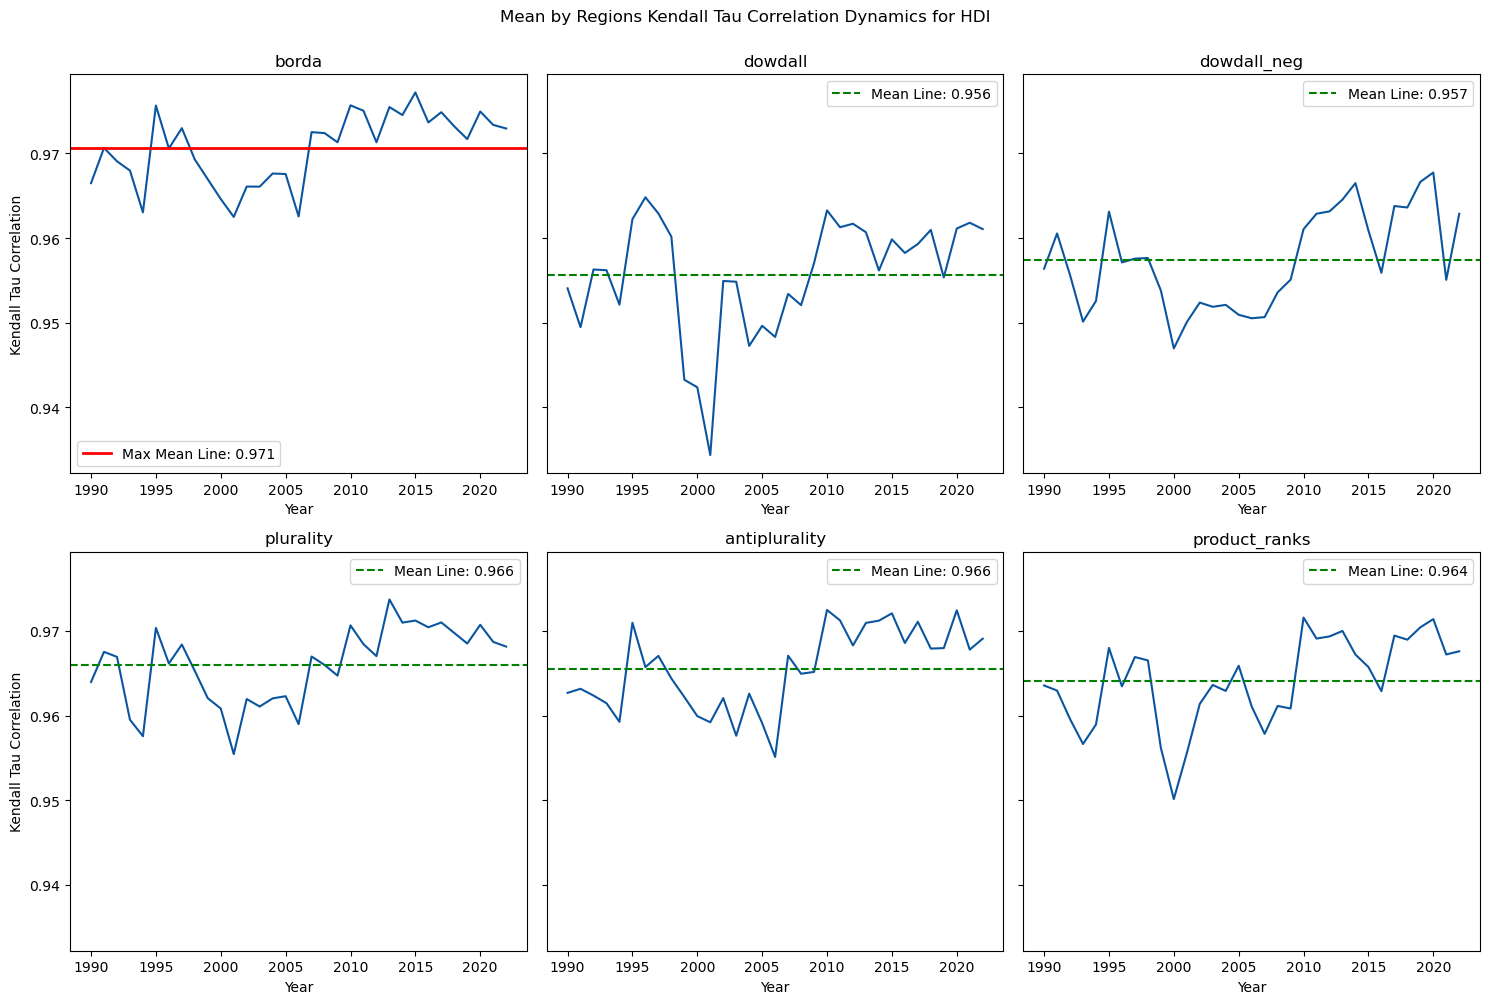

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kendall_tau_dynamics_by_rule(result_df):
    # Убираем столбцы 'a_mean' и 'g_mean'
    result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

    # Определение уникальных правил
    unique_rules = result_df_filtered['rule'].unique()

    # Определение числа строк и столбцов для размещения графиков
    num_plots = len(unique_rules)
    num_rows = (num_plots + 1) // 3  # Округляем вверх до ближайшего целого
    num_cols = min(3, num_plots)  # Максимум 3 столбца

    # Создание подграфиков
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10), constrained_layout=True, sharey=True)

    # Цвета для графиков
    palette = sns.color_palette('Blues', n_colors=len(unique_rules))
    color_product_ranks = palette[unique_rules.tolist().index('product_ranks')]  # Цвет 'product ranks'

    # Перебор по правилам и построение графиков
    max_mean_line = float('-inf')  # Инициализация максимального значения средней линии
    max_mean_line_rule = None  # Инициализация правила с максимальным значением средней линии
    for i, rule in enumerate(unique_rules):
        row = i // num_cols
        col = i % num_cols

        data_rule = result_df_filtered[result_df_filtered['rule'] == rule]
        data_rule = data_rule.sort_values(by='year')

        # Усреднение метрики по регионам для каждого года
        mean_values = data_rule.groupby('year')['Kendall_tau_distance'].mean()

        # Построение графика для текущего правила
        sns.lineplot(ax=axes[row, col], x=mean_values.index, y=mean_values.values, color=color_product_ranks, ci=None)

        # Добавление заголовка для текущего графика
        axes[row, col].set_title(rule)

        # Добавление прямой на уровне среднего по годам
        mean_line = mean_values.mean()
        axes[row, col].axhline(y=mean_line, color='green', linestyle='--', label=f'Mean Line: {mean_line:.3f}')
        
        # Обновление максимального значения средней линии и соответствующего правила
        if mean_line > max_mean_line:
            max_mean_line = mean_line
            max_mean_line_rule = rule
        
        # Установка меток оси X
        axes[row, col].set_xlabel('Year')

        # Установка меток оси Y только на левом графике каждой строки
        if col == 0:
            axes[row, col].set_ylabel('Kendall Tau Correlation')

    # Отображение максимального значения средней линии на одном графике
    if max_mean_line_rule:
        max_mean_line_data = result_df_filtered[result_df_filtered['rule'] == max_mean_line_rule]
        max_mean_line_data = max_mean_line_data.sort_values(by='year')
        max_mean_values = max_mean_line_data.groupby('year')['Kendall_tau_distance'].mean()
        
        row_max = list(unique_rules).index(max_mean_line_rule) // num_cols
        col_max = list(unique_rules).index(max_mean_line_rule) % num_cols
        
        axes[row_max, col_max].axhline(y=max_mean_line, color='red', linestyle='-', linewidth=2, label=f'Max Mean Line: {max_mean_line:.3f}')
        
        # Удаление зеленой линии
        axes[row_max, col_max].lines[-2].remove()

        # Установка легенды на графиках без красной линии
        for r, c in [(r, c) for r in range(num_rows) for c in range(num_cols) if (r, c) != (row_max, col_max)]:
            axes[r, c].legend()

        # Добавление легенды для красной линии
        axes[row_max, col_max].legend()

    # Установка общего заголовка для всех графиков
    plt.suptitle('Mean by Regions Kendall Tau Correlation Dynamics for HDI', y=1)  # Поднимаем заголовок на 5%

    # Отображение графиков
    plt.tight_layout()
    plt.savefig('kendall_tau_dynamics_regions_HDI.pdf', dpi=1000)
    plt.show()

# Пример использования функции
plot_kendall_tau_dynamics_by_rule(result_df)

In [113]:
# Удаление a_mean и g_mean из исходного DataFrame
result_df = result_df[result_df['rule'].isin(['borda', 'dowdall', 'dowdall_neg', 'black'])]

# Создание сводной таблицы
pivot_table = result_df.pivot_table(index=['year', 'region'], columns=['rule'], values='Kendall_tau_distance', aggfunc='mean')

# Округление значений до 5 знаков после запятой
pivot_table = pivot_table.round(5)
pivot_table.loc[('Average', ''), :] = pivot_table.mean(axis=0)
# Создание LaTeX-совместимого вывода
latex_output = pivot_table.to_latex(
    na_rep='',  # Заменить отсутствующие значения пустой строкой
    multicolumn=True,  # Использовать команду multicolumn для объединения ячеек
    multicolumn_format='c',  # Формат объединенных ячеек (центрированный)
    float_format="{:.5f}".format,  # Форматирование значений как чисел с плавающей запятой с пятью знаками после запятой
    longtable=True  # Использовать longtable для многостраничной таблицы
)

# Печать LaTeX-совместимого вывода
print(latex_output)

\begin{longtable}{llrrrr}
\toprule
 & rule & black & borda & dowdall & dowdall_neg \\
year & region &  &  &  &  \\
\midrule
\endfirsthead
\toprule
 & rule & black & borda & dowdall & dowdall_neg \\
year & region &  &  &  &  \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{5}{*}{1990} & Africa & 0.96756 & 0.96775 & 0.96302 & 0.96302 \\
 & Americas & 0.95991 & 0.96663 & 0.97044 & 0.90640 \\
 & Asia & 0.96914 & 0.96270 & 0.91465 & 0.96017 \\
 & Europe & 0.95780 & 0.95506 & 0.94758 & 0.89113 \\
 & Oceania & 0.86667 & 1.00000 & 1.00000 & 0.86667 \\
\cline{1-6}
\multirow[t]{5}{*}{1991} & Africa & 0.96966 & 0.96772 & 0.95448 & 0.96302 \\
 & Americas & 0.96258 & 0.95125 & 0.96552 & 0.92118 \\
 & Asia & 0.97183 & 0.96927 & 0.89758 & 0.94879 \\
 & Europe & 0.96000 & 0.96019 & 0.93952 & 0.87500 \\
 & Oceania & 1.00000 & 1.00000 & 1.00000 & 1.00000 \\
\cline{1-6}
\multirow[t]{5}{*}{1992} & Africa & 0.95822 & 0.96922

In [124]:
def calculate_indices_for_years(data):
    # Создание пустого DataFrame для хранения результатов
    result_df = pd.DataFrame(columns=['k', 'rule', 'Kendall_tau_distance', 'column', 'year'])

    # Перебор всех годов и выполнение операций для каждого года
    for year in range(1990, 2023):
        HDI_year = pd.DataFrame()

        # Получение данных для текущего года
        HDI_year[['HI', 'EI', 'II']] = data[['HI_{}'.format(year), 'EI_{}'.format(year), 'II_{}'.format(year)]]
        
        # Удаление строк с отсутствующими значениями
        HDI_year = HDI_year.dropna()

        # Создание DataFrame с данными для расчета индексов
        HDI_forscore = HDI_year[['HI', 'EI', 'II']]

        # Создание DataFrame для хранения правил
        rules_HDI = pd.DataFrame()
        rules_HDI['g_mean'] = np.power(np.prod(HDI_forscore, axis=1), 1 / HDI_forscore.shape[1])
        rules_HDI['a_mean'] = HDI_forscore.mean(axis=1)
        rules_HDI['borda'] = calculate_borda_scores(HDI_forscore, type='original')
        rules_HDI['dowdall'] = calculate_borda_scores(HDI_forscore, type='dowdall')
        rules_HDI['dowdall_neg'] = calculate_borda_scores(HDI_forscore, type='dowdall_neg')
        # Ранжирование данных и правил
        rank_rules = rules_HDI.rank(axis=0, method='min', ascending=False)
        rank_rules['plurality'] = plurality(HDI_forscore)
        rank_rules['antiplurality'] = antiplurality(HDI_forscore)
        rank_rules['product_ranks'] = product_rank(HDI_forscore)
        rank_rules['product_ranks_inverse'] = product_rank_inverse(HDI_forscore)
        
        group_assignments = {}

        # Задание значений К от 5 до 100 с шагом 10
        for k in range(20, 110, 20):
            # Инициализация списка для хранения групп для текущего значения К
            groups = []
            
            # Перебор стран и присвоение каждой стране группы в зависимости от значения К
            for country_index in range(len(HDI_year)):
                group_index = country_index // k + 1  # Определение индекса группы для текущей страны
                groups.append(group_index)
            
            # Сохранение группировки в словаре для текущего значения К
            group_assignments[k] = groups
    
        # Добавляем столбцы для каждого значения К
        for k, groups in group_assignments.items():
            rank_rules[f'k_{k}'] = groups
        for k, groups in group_assignments.items():
            HDI_year[f'k_{k}'] = groups        

        # Расчет расстояния Кендалла для каждого региона
        distances_df = calculate_kendall_tau_distance_for_groups(rank_rules, HDI_year)
        
        # Добавление информации о годе в DataFrame с результатами
        distances_df['year'] = year
        
        # Объединение результатов с общим DataFrame
        result_df = pd.concat([result_df, distances_df], ignore_index=True)

    return result_df

# Пример использования функции
result_df_group = calculate_indices_for_years(hdi_all)
print(result_df_group)

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2028366850.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distances_df = pd.concat([distances_df, distances_group_df], ignore_index=True)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\3585068717.py:60: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_df = pd.concat([result_df, distances_df], ignore_index=True)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2028366850.py:55: FutureWarning: The behavior of DataFrame concatenation w

C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2028366850.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distances_df = pd.concat([distances_df, distances_group_df], ignore_index=True)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2028366850.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  distances_df = pd.concat([distances_df, distances_group_df], ignore_index=True)
C:\Users\Eliza\AppData\Local\Temp\ipykernel_14040\2028366850.py:55: FutureWarning: The behavior of DataFrame con

      k                   rule  Kendall_tau_distance column  year
0     1                 g_mean              1.000000   k_40  1990
1     1                 a_mean              1.000000   k_40  1990
2     1                  borda              0.974228   k_40  1990
3     1                dowdall              0.966667   k_40  1990
4     1            dowdall_neg              0.956410   k_40  1990
...  ..                    ...                   ...    ...   ...
7159  3            dowdall_neg              1.000000  k_100  2022
7160  3              plurality              1.000000  k_100  2022
7161  3          antiplurality              1.000000  k_100  2022
7162  3          product_ranks              1.000000  k_100  2022
7163  3  product_ranks_inverse              1.000000  k_100  2022

[7164 rows x 5 columns]


In [176]:
import pandas as pd

# Assuming your DataFrame is named df
# Calculate the mean value for each rule
mean_values = result_df_group.groupby('rule')['Kendall_tau_distance'].mean().reset_index()

# Generate LaTeX table
latex_table = mean_values.to_latex(index=False)

print(latex_table)

\begin{tabular}{lr}
\toprule
rule & Kendall_tau_distance \\
\midrule
a_mean & 1.000000 \\
antiplurality & 0.965890 \\
borda & 0.970877 \\
dowdall & 0.955901 \\
dowdall_neg & 0.957706 \\
g_mean & 1.000000 \\
plurality & 0.966265 \\
product_ranks & 0.964402 \\
product_ranks_inverse & 0.962318 \\
\bottomrule
\end{tabular}



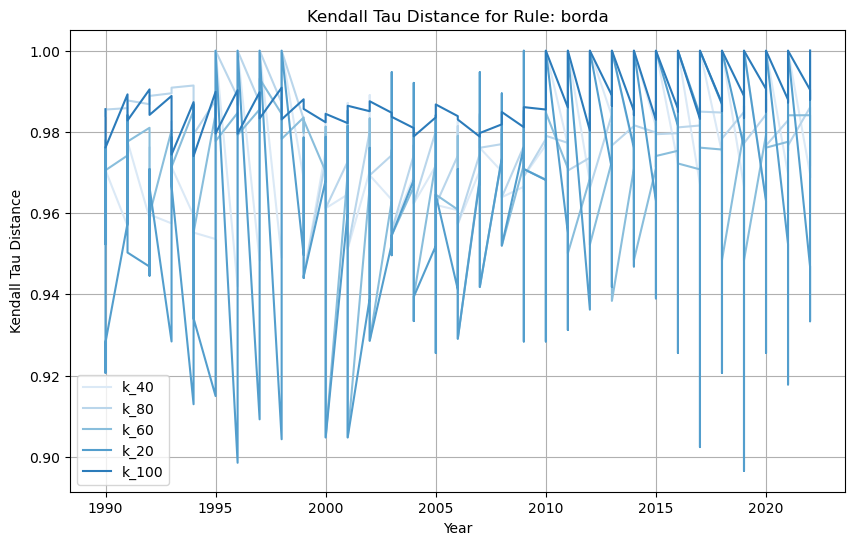

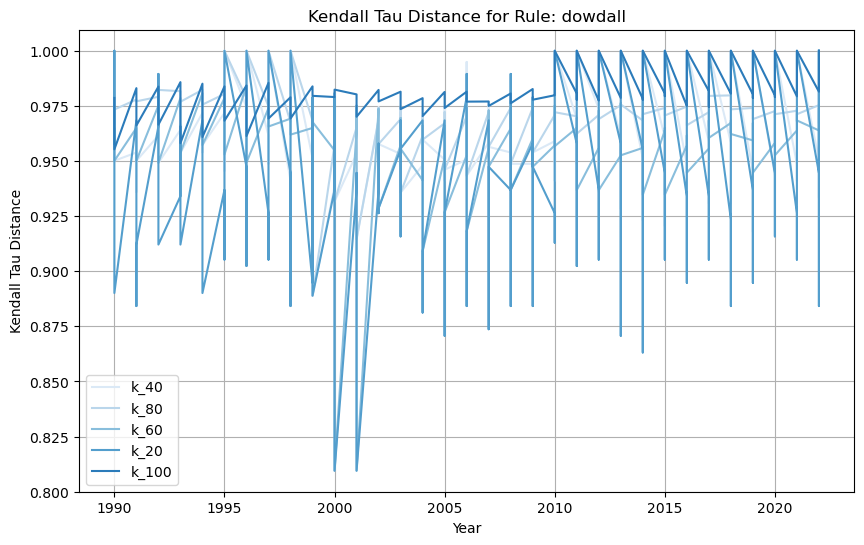

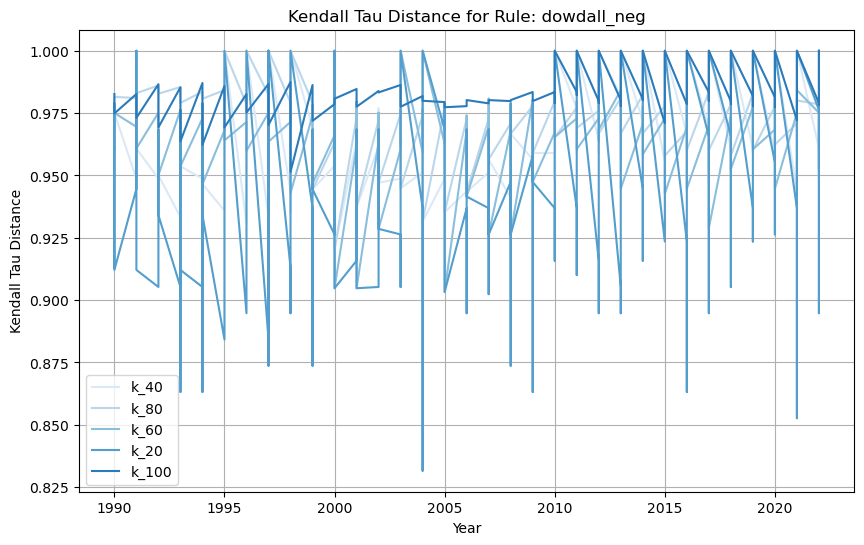

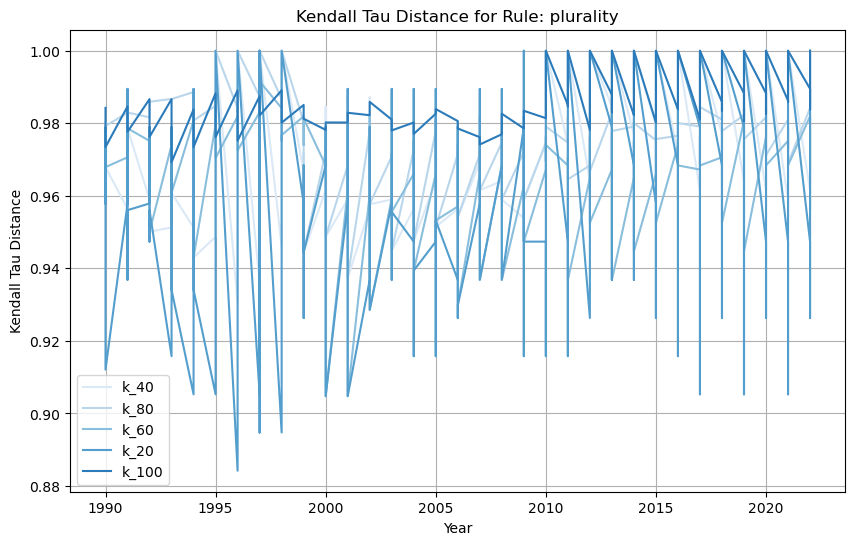

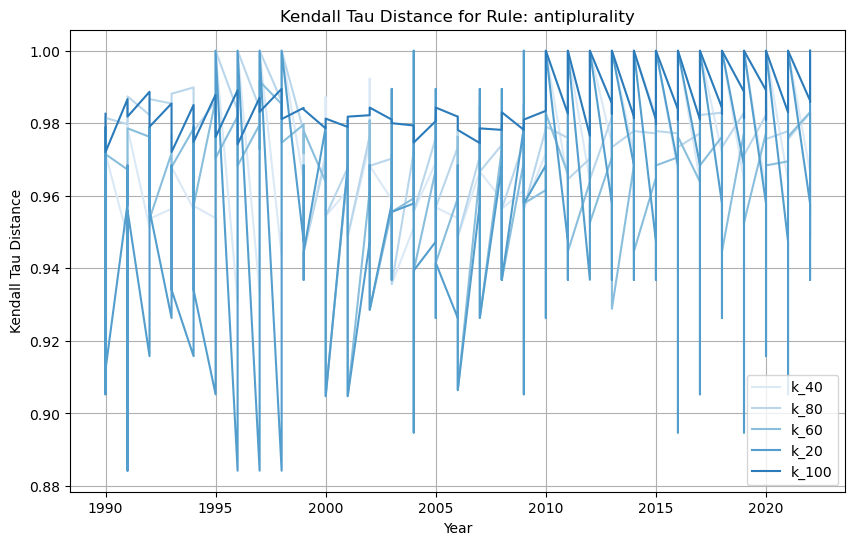

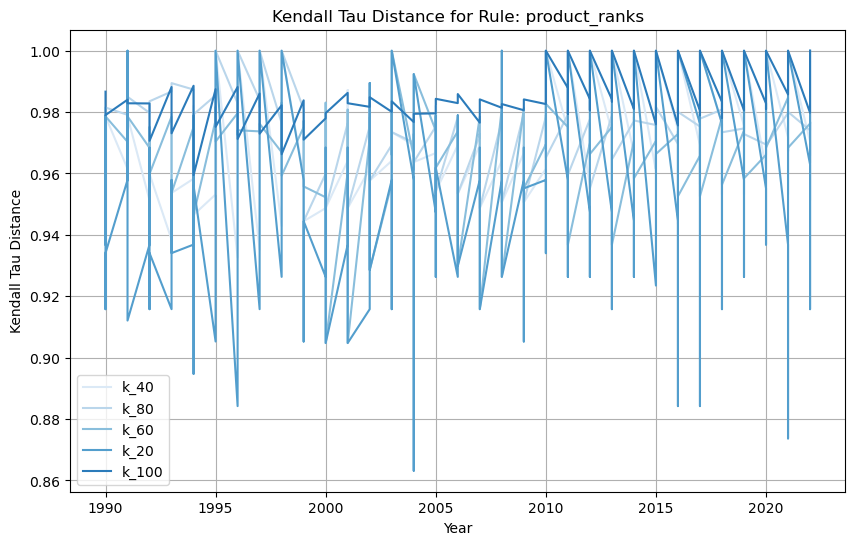

In [168]:
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных (предположим, что ваш DataFrame называется df)
# df = pd.read_csv("ваш_файл.csv")

# Отфильтровать данные, исключив a_mean, g_mean и product_ranks_inverse
filtered_df = result_df_group[~result_df_group['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

# Получить уникальные правила
rules = filtered_df['rule'].unique()

# Построение графиков для каждого правила
for rule in rules:
    # Фильтрация данных для текущего правила
    rule_df = filtered_df[filtered_df['rule'] == rule]
    
    # Создание графика
    plt.figure(figsize=(10, 6))
    for column in rule_df['column'].unique():
        column_data = rule_df[rule_df['column'] == column]
        plt.plot(column_data['year'], column_data['Kendall_tau_distance'], label=column)
    
    plt.title(f'Kendall Tau Distance for Rule: {rule}')
    plt.xlabel('Year')
    plt.ylabel('Kendall Tau Distance')
    plt.legend()
    plt.grid(True)
    plt.show()



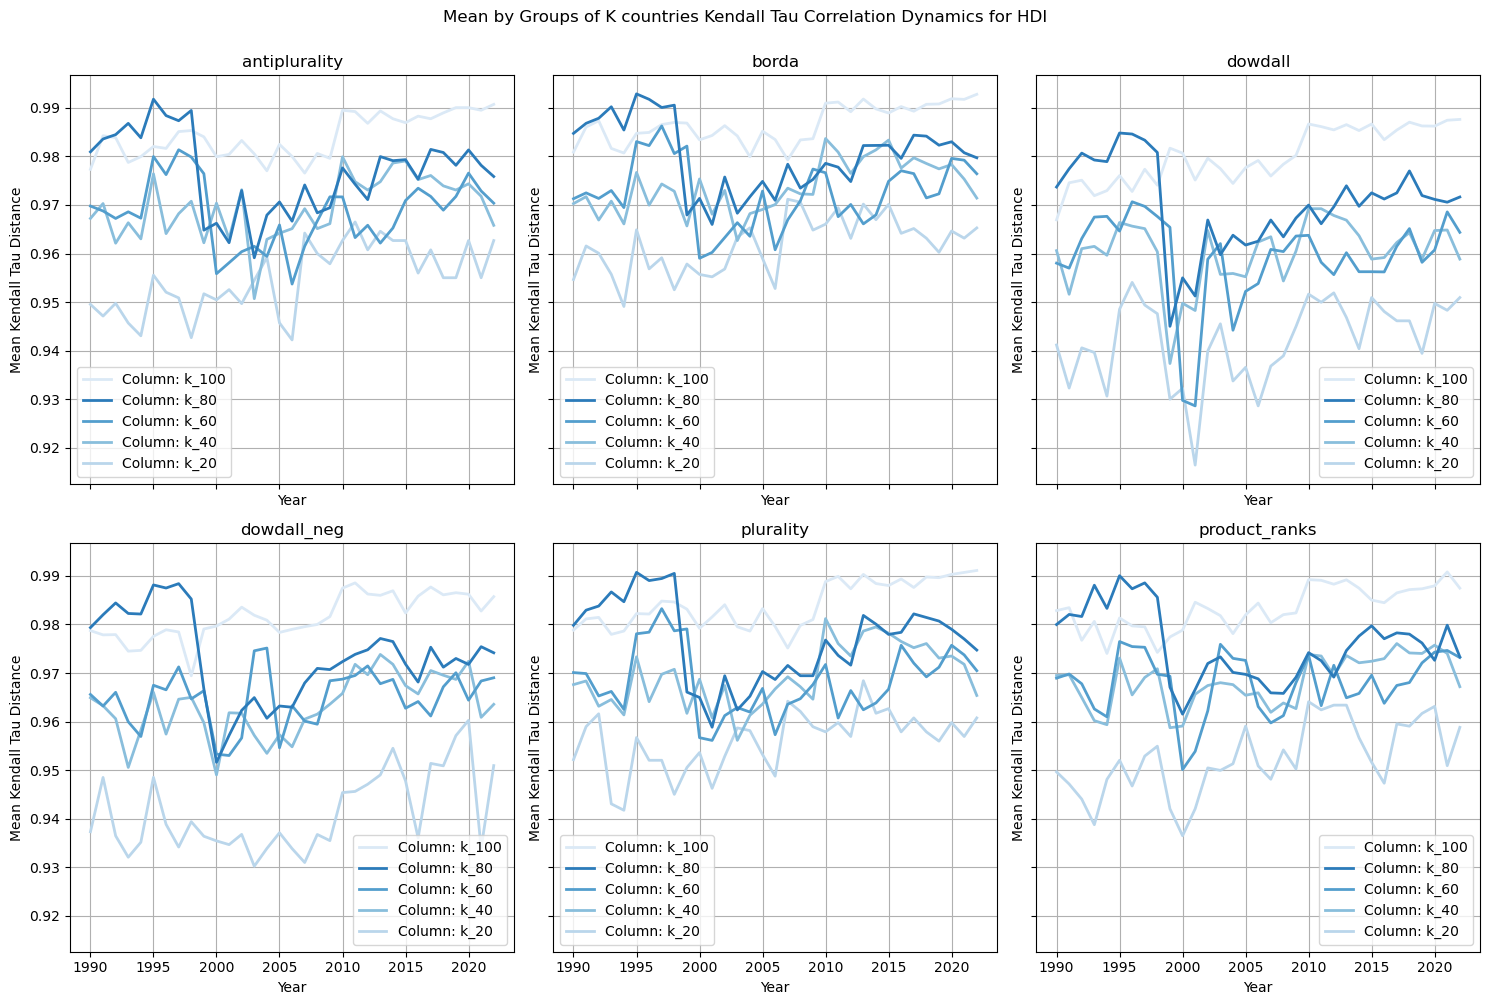

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load data (assuming your DataFrame is named df)
# df = pd.read_csv("your_file.csv")

# Отфильтровать данные, исключив a_mean, g_mean и product_ranks_inverse
filtered_df = result_df_group[~result_df_group['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

# Group data by rule, column, and year, then calculate the mean Kendall Tau Correlation for each group
mean_kendall_tau_df = filtered_df.groupby(['rule', 'column', 'year']).mean().reset_index()

# Define unique rules
rules = mean_kendall_tau_df['rule'].unique()

# Create subplots with shared x-axis and y-axis
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Set the color palette to "Blues"
sns.set_palette("Blues")

# Plotting graphs for each rule
for i, rule in enumerate(rules):
    ax = axs[i // 3, i % 3]  # Calculate subplot index
    
    for column in mean_kendall_tau_df['column'].unique():
        # Filter data for the current rule and column
        rule_column_df = mean_kendall_tau_df[(mean_kendall_tau_df['rule'] == rule) & (mean_kendall_tau_df['column'] == column)]
        
        # Group by year and calculate the mean Kendall Tau Correlation for each year
        mean_kendall_tau_year = rule_column_df.groupby('year')['Kendall_tau_distance'].mean()
        
        # Plot Kendall Tau Distance dynamics
        ax.plot(mean_kendall_tau_year.index, mean_kendall_tau_year.values, linestyle='-', linewidth=2, label=f'Column: {column}')
    
    # Sort legend labels by k in ascending order
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0].split('_')[1]), reverse=True))
    ax.legend(handles, labels)
    
    # Set plot title and labels
    ax.set_title(f'{rule}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean Kendall Tau Distance')
    ax.grid(True)
# Установка общего заголовка для всех графиков
plt.suptitle('Mean by Groups of K countries Kendall Tau Correlation Dynamics for HDI', y=1)  # Поднимаем заголовок на 5%
# Adjust layout
plt.tight_layout()
plt.savefig('kendall_tau_dynamics_groups_HDI.pdf', dpi=1000)
plt.show()

In [200]:
# Для DataFrame result_df
mean_by_rule_df = result_df.groupby('rule').mean('Kendall_tau_distance').reset_index()

# Для DataFrame result_df_group
mean_by_rule_group_df = result_df_group.groupby('rule').mean('Kendall_tau_distance').reset_index()

# Объединяем по столбцу "rule"
merged_df = mean_by_rule_df.merge(mean_by_rule_group_df, on='rule', suffixes=('_by_group', '_by_region'))

# Сортируем по столбцу "rule"
merged_df_sorted = merged_df.sort_values(by='rule')

# Создаем LaTeX таблицу
latex_table = merged_df_sorted.to_latex(index=False)

# Выводим LaTeX таблицу
print(latex_table)


\begin{tabular}{lrr}
\toprule
rule & Kendall_tau_distance_by_group & Kendall_tau_distance_by_region \\
\midrule
a_mean & 1.000000 & 1.000000 \\
antiplurality & 0.942911 & 0.965890 \\
borda & 0.948788 & 0.970877 \\
dowdall & 0.929984 & 0.955901 \\
dowdall_neg & 0.928991 & 0.957706 \\
g_mean & 1.000000 & 1.000000 \\
plurality & 0.943131 & 0.966265 \\
product_ranks & 0.940160 & 0.964402 \\
product_ranks_inverse & 0.942856 & 0.962318 \\
\bottomrule
\end{tabular}



In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (assuming your DataFrame is named df)
# df = pd.read_csv("your_file.csv")

# Отфильтровать данные, исключив a_mean, g_mean и product_ranks_inverse
filtered_df = result_df_group[~result_df_group['rule'].isin(['a_mean', 'g_mean', 'product_ranks_inverse'])]

# Group data by rule, column, and year, then calculate the mean Kendall Tau Correlation for each group
mean_kendall_tau_df = filtered_df.groupby(['rule', 'column', 'year']).mean().reset_index()

# Define unique rules
rules = mean_kendall_tau_df['rule'].unique()

# Create subplots with shared x-axis and y-axis
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Set the color palette to "Blues"
sns.set_palette("Blues")

# Plotting graphs for each rule
for i, rule in enumerate(rules):
    ax = axs[i // 3, i % 3]  # Calculate subplot index
    
    for column in mean_kendall_tau_df['column'].unique():
        # Filter data for the current rule and column
        rule_column_df = mean_kendall_tau_df[(mean_kendall_tau_df['rule'] == rule) & (mean_kendall_tau_df['column'] == column)]
        
        # Group by year and calculate the mean Kendall Tau Correlation for each year
        mean_kendall_tau_year = rule_column_df.groupby('year')['Kendall_tau_distance'].mean()
        
        # Plot Kendall Tau Distance dynamics
        ax.plot(mean_kendall_tau_year.index, mean_kendall_tau_year.values, linestyle='-', linewidth=2, label= {column})
    
    # Sort legend labels by k in ascending order
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0].split('_')[1]), reverse=True))
    ax.legend(handles, labels)
    
    # Plot average line
    mean_kendall_tau_avg = mean_kendall_tau_df[mean_kendall_tau_df['rule'] == rule]['Kendall_tau_distance'].mean()
    ax.axhline(mean_kendall_tau_avg, color='green', linestyle='-', linewidth=2, label= label = f'Mean Line: {mean_kendall_tau_avg:.3f}')
    
    # Set plot title and labels
    ax.set_title(f'Mean Kendall Tau Distance Dynamics for Rule: {rule}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Mean Kendall Tau Distance')
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (3329116256.py, line 44)

In [121]:
# Assume result_df_gr is your DataFrame
# Filter the DataFrame to include only rows where the rule is one of ['borda', 'dowdall', 'dowdall_neg', 'black']
result_df_gr = result_df[result_df['rule'].isin(['borda', 'dowdall', 'dowdall_neg', 'black'])]

# Check if the 'column' column contains string values
if result_df_gr['column'].dtype == 'object':
    # If 'column' contains string values, apply the .str.replace() operation
    result_df_gr['column'] = result_df_gr['column'].str.replace('k_', '').astype(int)

# Create a pivot table
pivot_table = result_df_gr.pivot_table(index=['year', 'column'], columns=['rule'], values='Kendall_tau_distance', aggfunc='mean')
# Округляем значения до 5 знаков после запятой
pivot_table = pivot_table.round(5)
pivot_table.loc[('Average', ''), :] = pivot_table.mean(axis=0)
# Создание LaTeX-совместимого вывода
latex_output = pivot_table.to_latex(
    na_rep='',  # Заменить отсутствующие значения пустой строкой
    multicolumn=True,  # Использовать команду multicolumn для объединения ячеек
    multicolumn_format='c',  # Формат объединенных ячеек (центрированный)
    float_format="{:.5f}".format,  # Форматирование значений как чисел с плавающей запятой с пятью знаками после запятой
    longtable=True  # Использовать longtable для многостраничной таблицы
)

# Печать LaTeX-совместимого вывода
print(latex_output)

\begin{longtable}{llrrrr}
\toprule
 & rule & black & borda & dowdall & dowdall_neg \\
year & column &  &  &  &  \\
\midrule
\endfirsthead
\toprule
 & rule & black & borda & dowdall & dowdall_neg \\
year & column &  &  &  &  \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{5}{*}{1990} & 20 & 0.96080 & 0.95465 & 0.94118 & 0.93734 \\
 & 40 & 0.97604 & 0.97028 & 0.96060 & 0.96491 \\
 & 60 & 0.97652 & 0.97128 & 0.95803 & 0.96560 \\
 & 80 & 0.98404 & 0.98473 & 0.97370 & 0.97935 \\
 & 100 & 0.98330 & 0.98088 & 0.96693 & 0.97873 \\
\cline{1-6}
\multirow[t]{5}{*}{1991} & 20 & 0.95860 & 0.96156 & 0.93232 & 0.94851 \\
 & 40 & 0.97660 & 0.97171 & 0.95162 & 0.96327 \\
 & 60 & 0.97685 & 0.97249 & 0.95700 & 0.96320 \\
 & 80 & 0.98497 & 0.98681 & 0.97745 & 0.98199 \\
 & 100 & 0.98266 & 0.98604 & 0.97456 & 0.97786 \\
\cline{1-6}
\multirow[t]{5}{*}{1992} & 20 & 0.95208 & 0.96007 & 0.94060 & 0.93650 \\
 & 40 & 0.96605 & 0.

C:\Users\Eliza\AppData\Local\Temp\ipykernel_18584\3714307226.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_gr['column'] = result_df_gr['column'].str.replace('k_', '').astype(int)


In [62]:
import pandas as pd

# Предположим, что result_df содержит ваши данные

# Удаление a_mean и g_mean из исходного DataFrame
result_df = result_df[result_df['rule'].isin(['borda', 'dowdall', 'dowdall_neg', 'kemeny'])]

# Убрать приписку "k_" из значений столбца "column"
result_df['column'] = result_df['column'].str.replace('k_', '').astype(int)

# Создаем сводную таблицу
pivot_table = result_df.pivot_table(index=['year', 'column'], columns=['rule'], values='Kendall_tau_distance', aggfunc='mean')

# Округляем значения до 5 знаков после запятой
pivot_table = pivot_table.round(5)

# Сортируем индекс по столбцу 'column' внутри каждого года
pivot_table = pivot_table.sort_index(level=['year', 'column'])

print(pivot_table)

rule           borda  dowdall  dowdall_neg   kemeny
year column                                        
1990 10      0.95304  0.90760      0.93257  0.95304
     40      0.97028  0.96060      0.96491  0.97028
     70      0.96116  0.93659      0.94999  0.96116
     100     0.98088  0.96693      0.97873  0.98088
1991 10      0.96399  0.90833      0.92986  0.96399
...              ...      ...          ...      ...
2021 100     0.99173  0.98744      0.98276  0.99173
2022 10      0.95750  0.93797      0.92476  0.95750
     40      0.97142  0.95886      0.96356  0.97110
     70      0.97690  0.96844      0.97457  0.97656
     100     0.99278  0.98761      0.98572  0.99278

[132 rows x 4 columns]


In [63]:
# Создание LaTeX-совместимого вывода
latex_output = pivot_table.to_latex(
    na_rep='',  # Заменить отсутствующие значения пустой строкой
    multicolumn=True,  # Использовать команду multicolumn для объединения ячеек
    multicolumn_format='c',  # Формат объединенных ячеек (центрированный)
    float_format="{:.5f}".format,  # Форматирование значений как чисел с плавающей запятой с пятью знаками после запятой
    longtable=True  # Использовать longtable для многостраничной таблицы
)

# Печать LaTeX-совместимого вывода
print(latex_output)


\begin{longtable}{llrrrr}
\toprule
 & rule & borda & dowdall & dowdall_neg & kemeny \\
year & column &  &  &  &  \\
\midrule
\endfirsthead
\toprule
 & rule & borda & dowdall & dowdall_neg & kemeny \\
year & column &  &  &  &  \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{4}{*}{1990} & 10 & 0.95304 & 0.90760 & 0.93257 & 0.95304 \\
 & 40 & 0.97028 & 0.96060 & 0.96491 & 0.97028 \\
 & 70 & 0.96116 & 0.93659 & 0.94999 & 0.96116 \\
 & 100 & 0.98088 & 0.96693 & 0.97873 & 0.98088 \\
\cline{1-6}
\multirow[t]{4}{*}{1991} & 10 & 0.96399 & 0.90833 & 0.92986 & 0.96399 \\
 & 40 & 0.97171 & 0.95162 & 0.96327 & 0.97193 \\
 & 70 & 0.96938 & 0.94944 & 0.95358 & 0.96965 \\
 & 100 & 0.98604 & 0.97456 & 0.97786 & 0.98604 \\
\cline{1-6}
\multirow[t]{4}{*}{1992} & 10 & 0.96269 & 0.92778 & 0.91944 & 0.96269 \\
 & 40 & 0.96690 & 0.96101 & 0.96060 & 0.96690 \\
 & 70 & 0.97557 & 0.95248 & 0.96312 & 0.97577 \\
 & 100 & 0.98733 &

In [ ]:
# Adjust the display settings to show all rows
pd.set_option('display.max_rows', None)

# Now when you display your DataFrame, all rows will be shown
print(result_df)

In [ ]:
# Group by 'rule', 'column', and 'year' and calculate the mean
grouped = result_df.groupby(['rule', 'column', 'year']).agg(mean_distance=('Kendall_tau_distance', 'mean')).reset_index()

print(grouped)

C:\Users\Eliza\AppData\Local\Temp\ipykernel_18584\3096526573.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', data=data_rule, color=palette[i], ci=None)
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\AppData\Local\Temp\ipykernel_18584\3096526573.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(ax=axes[i], x='year', y='

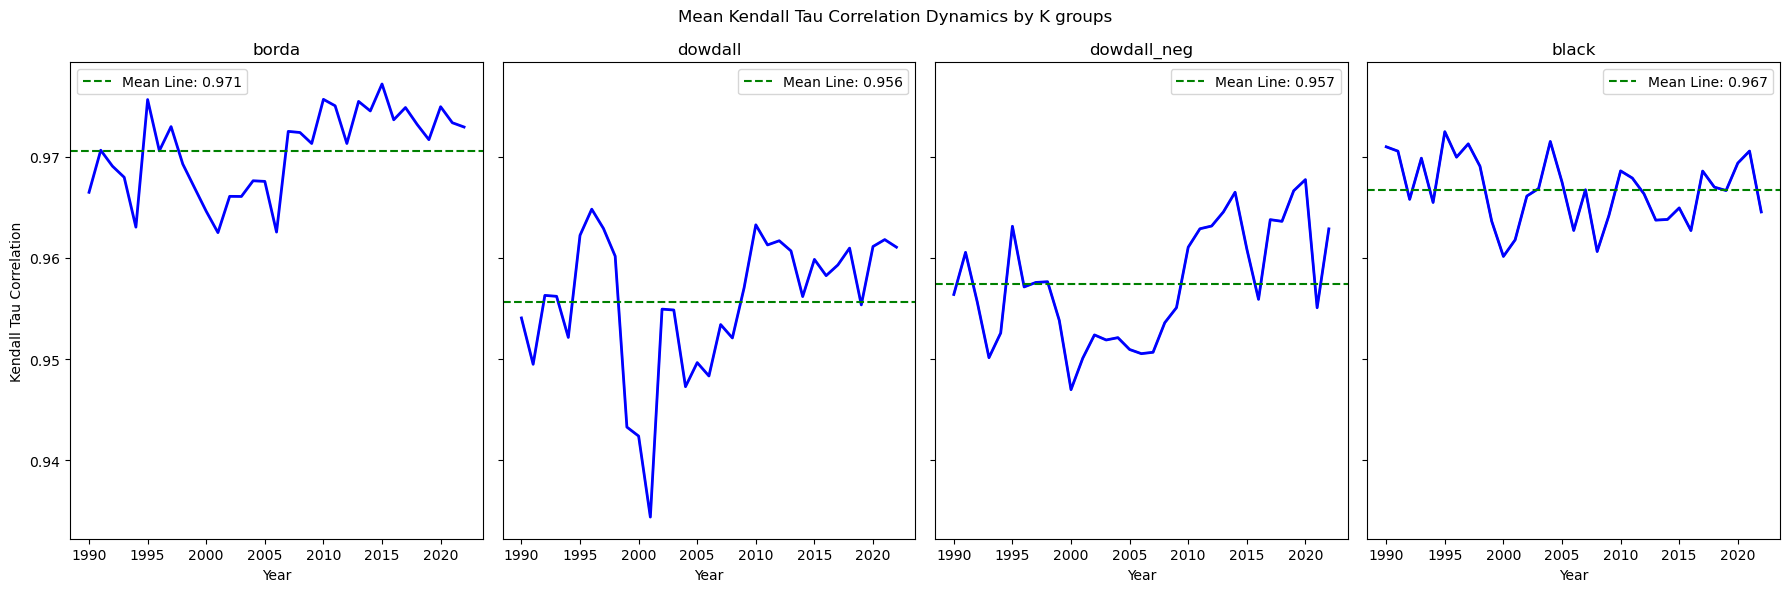

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_kendall_tau_dynamics_by_rule(result_df):
    # Убираем столбцы 'a_mean' и 'g_mean'
    result_df_filtered = result_df[~result_df['rule'].isin(['a_mean', 'g_mean'])]

    # Определение уникальных правил
    unique_rules = result_df_filtered['rule'].unique()

    # Создание графиков в одном ряду
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 6), sharey=True)

    # Цвета для графиков
    palette = sns.color_palette('Blues', n_colors=len(unique_rules))

    # Перебор по правилам и построение графиков
    for i, rule in enumerate(unique_rules):
        data_rule = result_df_filtered[result_df_filtered['rule'] == rule]
        data_rule = data_rule.sort_values(by='year')

        # Построение графика для текущего правила
        sns.lineplot(ax=axes[i], x='year', y='Kendall_tau_distance', data=data_rule, color=palette[i], ci=None)

        # Добавление заголовка для текущего графика
        axes[i].set_title(rule)

        # Установка меток оси X
        axes[i].set_xlabel('Year')

        # Установка меток оси Y только на левом графике
        if i == 0:
            axes[i].set_ylabel('Kendall Tau Correlation')

        # Вычисление среднего значения для текущего правила
        mean_values = data_rule.groupby('year')['Kendall_tau_distance'].mean()
        axes[i].plot(mean_values.index, mean_values.values, color='blue', linewidth=2)

        # Добавление прямой на уровне среднего по годам
        mean_line = mean_values.mean()
        axes[i].axhline(y=mean_line, color='green', linestyle='--', label=f'Mean Line: {mean_line:.3f}')
        axes[i].legend()
        

    # Установка общего заголовка для всех графиков
    plt.suptitle('Mean Kendall Tau Correlation Dynamics by K groups')

    # Отображение графиков
    plt.tight_layout()
    plt.savefig('kendall_tau_dynamics.png', dpi=1000)
    plt.show()

# Пример использования функции
plot_kendall_tau_dynamics_by_rule(result_df)

In [ ]:
pip install voting

In [ ]:
import pandas as pd

# Sample dataset of country rankings
rank_components = HDI_forscore.rank(axis=0, method='min', ascending=False).round().astype(int)
rank_components['country'] = HDI_2022['iso3']

# Convert the dictionary to a DataFrame
rankings_df = rank_components

In [108]:
def condorcet(rankings):
    pairwise_counts = {}
    
    # Iterate through each pair of countries
    for i, row1 in rankings.iterrows():
        for j, row2 in rankings.iterrows():
            if i != j:  # Exclude self-comparisons
                count_i_j = (row1[rankings.columns].astype(float) > row2[rankings.columns].astype(float)).sum()
                count_j_i = (row1[rankings.columns].astype(float) < row2[rankings.columns].astype(float)).sum()
                pairwise_counts[(i, j)] = 1 if count_i_j > count_j_i else 0
    
    # Convert the dictionary to a DataFrame
    pairwise_df = pd.DataFrame(pairwise_counts.values(), index=pd.MultiIndex.from_tuples(pairwise_counts.keys())).unstack(fill_value=0)
    
    # Add country names as both row and column labels
    pairwise_df.columns = pairwise_df.columns.get_level_values(1)
    pairwise_df.index = pairwise_df.index.get_level_values(0)
    
    # Calculate total scores for each country
    scores = pairwise_df.sum(axis=1)
    return scores

In [38]:
import pandas as pd
import numpy as np

def calculate_indices_for_years_all_rules(data):
    # Create an empty DataFrame to store the results
    result_df = pd.DataFrame(columns=['rule', 'Kendall_tau_distance', 'region', 'year'])

    # Iterate over all years and perform operations for each year
    for year in range(1990, 2023):
        HDI_year = pd.DataFrame()

        # Get data for the current year
        HDI_year[['HI', 'EI', 'II', 'region']] = data[['HI_{}'.format(year), 'EI_{}'.format(year), 'II_{}'.format(year), 'region']]
        
        # Remove rows with missing values
        HDI_year = HDI_year.dropna()

        # Create a DataFrame with data for calculating indices
        HDI_forscore = HDI_year[['HI', 'EI', 'II']]

        # Create a DataFrame to store rules
        rules_HDI = pd.DataFrame()
        rules_HDI['g_mean'] = np.power(np.prod(HDI_forscore, axis=1), 1 / HDI_forscore.shape[1])
        rules_HDI['a_mean'] = HDI_forscore.mean(axis=1)
        rules_HDI['borda'] = calculate_borda_scores(HDI_forscore, type='original')
        rules_HDI['dowdall'] = calculate_borda_scores(HDI_forscore, type='dowdall')
        rules_HDI['dowdall_neg'] = calculate_borda_scores(HDI_forscore, type='dowdall_neg')
        
        
        rank_rules = rules_HDI.rank(axis=0, method='min', ascending=False)
        rank_rules['plurality'] = plurality(HDI_forscore)
        rank_rules['antiplurality'] = antiplurality(HDI_forscore)
        rank_rules['product_ranks'] = product_rank(HDI_forscore)
        rank_rules['product_ranks_inverse'] = product_rank_inverse(HDI_forscore)
        rank_rules['region'] = HDI_year['region']
        rank_components = HDI_forscore.rank(axis=0, method='min', ascending=False)

        # Ранжирование данных и правил
        rank_rules = rules_HDI.rank(axis=0, method='min', ascending=False)
        
        # Ranking data and rules
        rank_rules = rules_HDI.rank(axis=0, method='min', ascending=False)
        rank_rules['region'] = HDI_year['region']
        rank_components = HDI_forscore.rank(axis=0, method='min', ascending=False)

        # Calculate Kendall tau distance for each region
        distances_df = calculate_kendall_tau_distance_for_regions(rank_rules, HDI_year)
        
        # Add year information to the result DataFrame
        distances_df['year'] = year
        
        # Merge the results with the overall DataFrame
        result_df = pd.concat([result_df, distances_df], ignore_index=True)

    return result_df

# Example usage of the function
result_df = calculate_indices_for_years_all_rules(hdi_all)
print(result_df)


KeyError: 'region'

In [135]:
# Удаление a_mean и g_mean из исходного DataFrame
result_df = result_df[result_df['rule'].isin(['borda', 'dowdall', 'dowdall_neg', 'black'])]

# Создание сводной таблицы
pivot_table = result_df.pivot_table(index=['year', 'region'], columns=['rule'], values='Kendall_tau_distance', aggfunc='mean')

# Округление значений до 5 знаков после запятой
pivot_table = pivot_table.round(5)
pivot_table.loc[('Average', ''), :] = pivot_table.mean(axis=0)
# Создание LaTeX-совместимого вывода
latex_output = pivot_table.to_latex(
    na_rep='',  # Заменить отсутствующие значения пустой строкой
    multicolumn=True,  # Использовать команду multicolumn для объединения ячеек
    multicolumn_format='c',  # Формат объединенных ячеек (центрированный)
    float_format="{:.5f}".format,  # Форматирование значений как чисел с плавающей запятой с пятью знаками после запятой
    longtable=True  # Использовать longtable для многостраничной таблицы
)

# Печать LaTeX-совместимого вывода
print(latex_output)

\begin{longtable}{llrrrr}
\toprule
 & rule & black & borda & dowdall & dowdall_neg \\
year & region &  &  &  &  \\
\midrule
\endfirsthead
\toprule
 & rule & black & borda & dowdall & dowdall_neg \\
year & region &  &  &  &  \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{5}{*}{1990} & Africa & 0.95617 & 0.96775 & 0.96302 & 0.96302 \\
 & Americas & 0.95523 & 0.96663 & 0.97044 & 0.90640 \\
 & Asia & 0.96914 & 0.96270 & 0.91465 & 0.96017 \\
 & Europe & 0.94980 & 0.95506 & 0.94758 & 0.89113 \\
 & Oceania & 0.86667 & 1.00000 & 1.00000 & 0.86667 \\
\cline{1-6}
\multirow[t]{5}{*}{1991} & Africa & 0.96193 & 0.96772 & 0.95448 & 0.96302 \\
 & Americas & 0.96126 & 0.95125 & 0.96552 & 0.92118 \\
 & Asia & 0.96900 & 0.96927 & 0.89758 & 0.94879 \\
 & Europe & 0.95307 & 0.96019 & 0.93952 & 0.87500 \\
 & Oceania & 1.00000 & 1.00000 & 1.00000 & 1.00000 \\
\cline{1-6}
\multirow[t]{5}{*}{1992} & Africa & 0.94973 & 0.96922

In [71]:
# Создание LaTeX-совместимого вывода
latex_output = pivot_table.to_latex(
    na_rep='',  # Заменить отсутствующие значения пустой строкой
    multicolumn=True,  # Использовать команду multicolumn для объединения ячеек
    multicolumn_format='c',  # Формат объединенных ячеек (центрированный)
    float_format="{:.5f}".format,  # Форматирование значений как чисел с плавающей запятой с пятью знаками после запятой
    longtable=True  # Использовать longtable для многостраничной таблицы
)

# Печать LaTeX-совместимого вывода
print(latex_output)

\begin{longtable}{lrrrr}
\toprule
rule & borda & dowdall & dowdall_neg & kemeny \\
\midrule
\endfirsthead
\toprule
rule & borda & dowdall & dowdall_neg & kemeny \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
0 & 0.96775 & 0.96302 & 0.96302 & 0.96775 \\
1 & 0.96663 & 0.97044 & 0.90640 & 0.96663 \\
2 & 0.96270 & 0.91465 & 0.96017 & 0.96270 \\
3 & 0.95506 & 0.94758 & 0.89113 & 0.95506 \\
4 & 1.00000 & 1.00000 & 0.86667 & 1.00000 \\
5 & 0.96772 & 0.95448 & 0.96302 & 0.96772 \\
6 & 0.95125 & 0.96552 & 0.92118 & 0.95125 \\
7 & 0.96927 & 0.89758 & 0.94879 & 0.96715 \\
8 & 0.96019 & 0.93952 & 0.87500 & 0.96019 \\
9 & 1.00000 & 1.00000 & 1.00000 & 1.00000 \\
10 & 0.96922 & 0.96586 & 0.96302 & 0.96922 \\
11 & 0.95028 & 0.97044 & 0.93596 & 0.95028 \\
12 & 0.95397 & 0.90249 & 0.95089 & 0.95185 \\
13 & 0.94286 & 0.95565 & 0.89405 & 0.94286 \\
14 & 1.00000 & 1.00000 & 1.00000 & 1.00000 \\
15 & 0.96052 & 0.95943 & 0.97367 & 0.960

ROBUSTNESS TO THE EXCLUSION

In [89]:
def count_differing_pairs(vector1, vector2):
    if len(vector1) != len(vector2):
        raise ValueError("Vectors must have the same length")

    return sum(1 for elem1, elem2 in zip(vector1, vector2) if elem1 != elem2)

# Пример использования:
vector1 = [1, 2, 3, 4, 5]
vector2 = [1, 3, 3, 4, 6]

result = count_differing_pairs(vector1, vector2)
print("Количество отличающихся пар элементов:", result)


Количество отличающихся пар элементов: 2


In [212]:
import pandas as pd
import numpy as np
from scipy.stats import kendalltau

def count_differing_pairs(vector1, vector2):
    if len(vector1) != len(vector2):
        raise ValueError("Vectors must have the same length")

    return sum(1 for elem1, elem2 in zip(vector1, vector2) if elem1 != elem2)

def calculate_canberra_distances(data):
    results_list = []

    for year in range(1990, 2023):
        HDI_year = pd.DataFrame()

        # Get data for the current year
        HDI_year[['HI', 'EI', 'II', 'region']] = data[['HI_{}'.format(year), 'EI_{}'.format(year), 'II_{}'.format(year), 'region']]

        # Remove rows with missing values
        HDI_year = HDI_year.dropna()

        # Create a DataFrame with data for calculating indices
        HDI_forscore = HDI_year[['HI', 'EI', 'II']]

        # Создание DataFrame для хранения правил
        rules_HDI = pd.DataFrame()
        rules_HDI['g_mean'] = np.power(np.prod(HDI_forscore, axis=1), 1 / HDI_forscore.shape[1])
        rules_HDI['a_mean'] = HDI_forscore.mean(axis=1)
        rules_HDI['borda'] = calculate_borda_scores(HDI_forscore, type='original')
        rules_HDI['dowdall'] = calculate_borda_scores(HDI_forscore, type='dowdall')
        rules_HDI['dowdall_neg'] = calculate_borda_scores(HDI_forscore, type='dowdall_neg')
        rank_rules = rules_HDI.rank(axis=0, method='min', ascending=False)
        rank_rules['plurality'] = plurality(HDI_forscore)
        rank_rules['antiplurality'] = antiplurality(HDI_forscore)
        rank_rules['product_ranks'] = product_rank(HDI_forscore)
        rank_rules['product_ranks_inverse'] = product_rank_inverse(HDI_forscore)
        
        # Iterate over each component
        for component in ['HI', 'EI', 'II']:
            # Exclude the current component
            HDI_excluded = HDI_forscore.drop(component, axis=1)

            # Создание DataFrame для хранения правил
            rules_HDI_excluded = pd.DataFrame()
            rules_HDI_excluded['g_mean'] = np.power(np.prod(HDI_excluded, axis=1), 1 / HDI_excluded.shape[1])
            rules_HDI_excluded['a_mean'] = HDI_excluded.mean(axis=1)
            rules_HDI_excluded['borda'] = calculate_borda_scores(HDI_excluded, type='original')
            rules_HDI_excluded['dowdall'] = calculate_borda_scores(HDI_excluded, type='dowdall')
            rules_HDI_excluded['dowdall_neg'] = calculate_borda_scores(HDI_excluded, type='dowdall_neg')
            
            # Ранжирование данных и правил
            rank_rules_excluded = rules_HDI_excluded.rank(axis=0, method='min', ascending=False)
            rank_rules_excluded['plurality'] = plurality(HDI_excluded)
            rank_rules_excluded['antiplurality'] = antiplurality(HDI_excluded)
            rank_rules_excluded['product_ranks'] = product_rank(HDI_excluded)
            rank_rules_excluded['product_ranks_inverse'] = product_rank_inverse(HDI_excluded)
    
            # Calculate the proportion of differing pairs divided by the total number of pairs
            differing_pairs_g_mean = count_differing_pairs(rank_rules['g_mean'], rank_rules_excluded['g_mean']) 
            differing_pairs_a_mean = count_differing_pairs(rank_rules['a_mean'], rank_rules_excluded['a_mean']) 
            differing_pairs_borda = count_differing_pairs(rank_rules['borda'], rank_rules_excluded['borda']) 
            differing_pairs_dowdall = count_differing_pairs(rank_rules['dowdall'], rank_rules_excluded['dowdall'])  
            differing_pairs_dowdall_neg = count_differing_pairs(rank_rules['dowdall_neg'], rank_rules_excluded['dowdall_neg']) 
            differing_pairs_plurality = count_differing_pairs(rank_rules['plurality'], rank_rules_excluded['plurality']) 
            differing_pairs_antiplurality = count_differing_pairs(rank_rules['antiplurality'], rank_rules_excluded['antiplurality']) 
            differing_pairs_ranks = count_differing_pairs(rank_rules['product_ranks'], rank_rules_excluded['product_ranks']) 
            differing_pairs_ranks_inverse = count_differing_pairs(rank_rules['product_ranks_inverse'], rank_rules_excluded['product_ranks_inverse']) 
            
            # Add results to the list
            results_list.append({'rule': 'g_mean', 'differing_pairs': differing_pairs_g_mean, 'component_excluded': component, 'year': year})
            results_list.append({'rule': 'a_mean', 'differing_pairs': differing_pairs_a_mean, 'component_excluded': component, 'year': year})
            results_list.append({'rule': 'borda', 'differing_pairs': differing_pairs_borda, 'component_excluded': component, 'year': year})
            results_list.append({'rule': 'dowdall', 'differing_pairs': differing_pairs_dowdall, 'component_excluded': component, 'year': year})
            results_list.append({'rule': 'dowdall_neg', 'differing_pairs': differing_pairs_dowdall_neg, 'component_excluded': component, 'year': year})
            results_list.append({'rule': 'plurality', 'differing_pairs': differing_pairs_plurality, 'component_excluded': component, 'year': year})
            results_list.append({'rule': 'antiplurality', 'differing_pairs': differing_pairs_antiplurality, 'component_excluded': component, 'year': year})
            results_list.append({'rule': 'product_ranks', 'differing_pairs': differing_pairs_ranks, 'component_excluded': component, 'year': year})
            

    # Convert the list of results to a DataFrame
    results = pd.DataFrame(results_list)
    return results

# Calculate the proportion of differing pairs
results = calculate_canberra_distances(hdi_all)

# Display the results
print(results)

              rule  differing_pairs component_excluded  year
0           g_mean              123                 HI  1990
1           a_mean              124                 HI  1990
2            borda              131                 HI  1990
3          dowdall              136                 HI  1990
4      dowdall_neg              127                 HI  1990
..             ...              ...                ...   ...
787        dowdall              182                 II  2022
788    dowdall_neg              183                 II  2022
789      plurality              178                 II  2022
790  antiplurality              181                 II  2022
791  product_ranks              183                 II  2022

[792 rows x 4 columns]


In [214]:
import pandas as pd

# Предположим, что у вас есть DataFrame с данными, назовем его df
# В df должны быть столбцы 'rule', 'differing_pairs_proportion', 'component_excluded' и 'year'

# Группировка данных по правилам и годам, затем вычисление дисперсии
variance_per_rule_per_year = results.groupby(['rule', 'year'])['differing_pairs'].var()
# Вывод результата
print(variance_per_rule_per_year)


rule           year
a_mean         1990    26.333333
               1991    16.333333
               1992     9.000000
               1993     1.000000
               1994    19.000000
                         ...    
product_ranks  2018     0.000000
               2019     4.000000
               2020    10.333333
               2021    21.333333
               2022     2.333333
Name: differing_pairs, Length: 264, dtype: float64


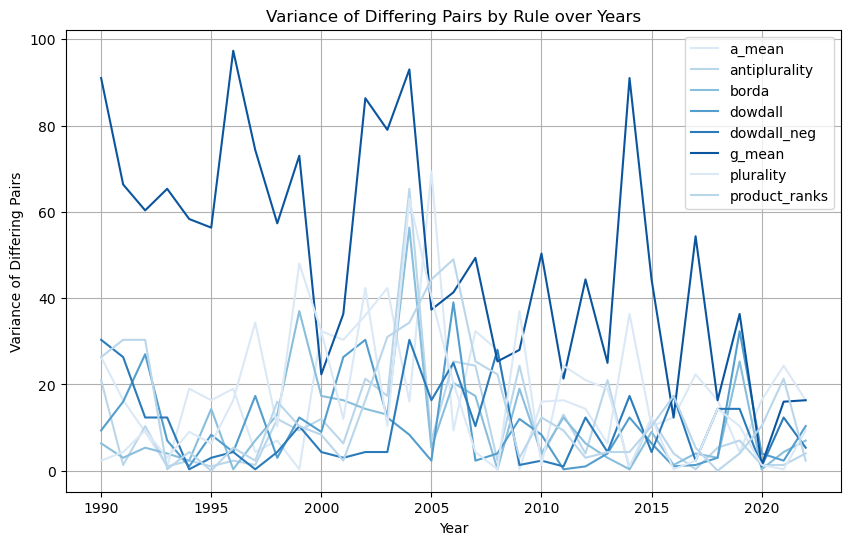

In [216]:
import matplotlib.pyplot as plt

# Создание графика
plt.figure(figsize=(10, 6))

# Итерация по каждому правилу
for rule, data in variance_per_rule_per_year.groupby(level=0):
    # Извлечение данных для текущего правила
    years = data.index.get_level_values('year')
    values = data.values
    
    # Построение линии для текущего правила
    plt.plot(years, values, label=rule)

# Добавление меток и заголовка
plt.xlabel('Year')
plt.ylabel('Variance of Differing Pairs')
plt.title('Variance of Differing Pairs by Rule over Years')

# Добавление легенды
plt.legend()

# Отображение графика
plt.grid(True)
plt.show()

C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

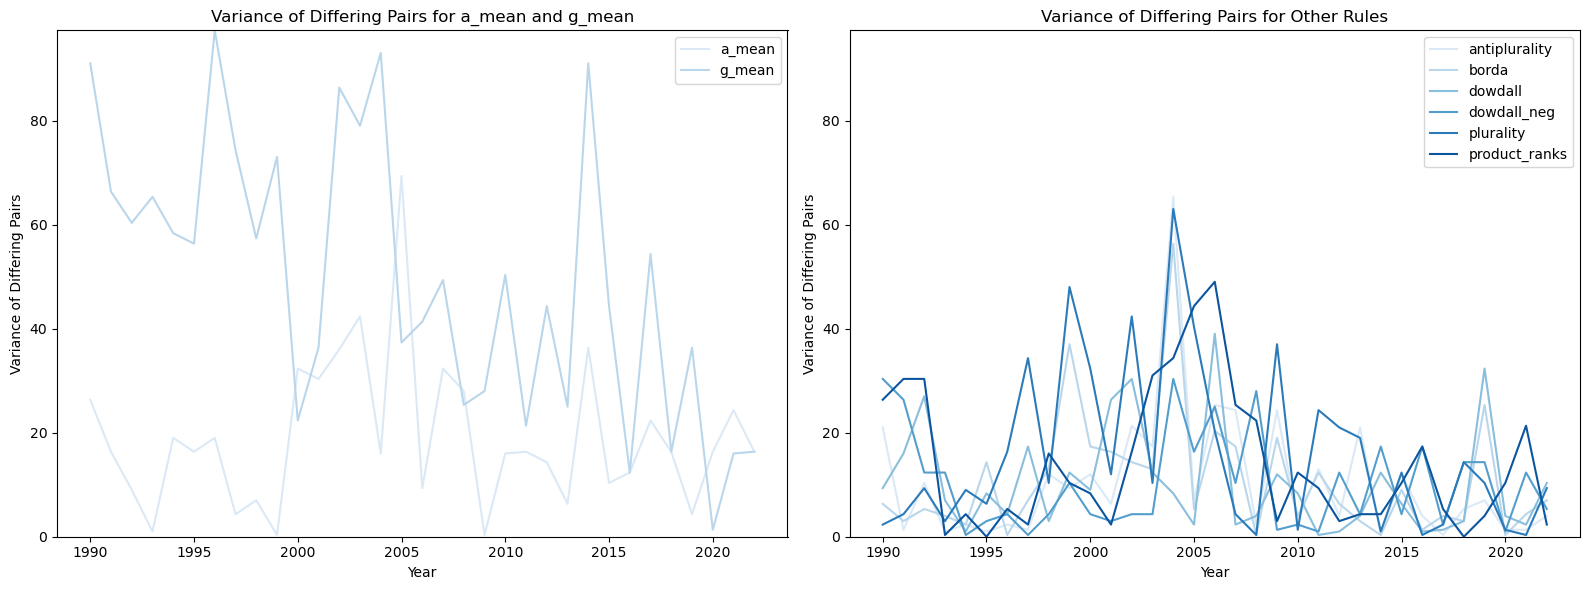

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем список правил, которые хотим отобразить на первом графике
rules_to_plot_1 = ['a_mean', 'g_mean']

# Создаем список правил, которые хотим отобразить на втором графике
rules_to_plot_2 = variance_per_rule_per_year.index.levels[0].difference(rules_to_plot_1)

# Создаем фигуру и два подграфика
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Получаем максимальное значение для обоих графиков
max_value = variance_per_rule_per_year.max().max()

# График для первого списка правил
for rule in rules_to_plot_1:
    data = variance_per_rule_per_year.loc[rule]
    sns.lineplot(x=data.index, y=data.values, ax=axes[0], label=rule)

# График для второго списка правил
for rule in rules_to_plot_2:
    data = variance_per_rule_per_year.loc[rule]
    sns.lineplot(x=data.index, y=data.values, ax=axes[1], label=rule)

# Устанавливаем пределы для оси y на обоих графиках
for ax in axes:
    ax.set_ylim(0, max_value)

# Добавляем заголовки и подписи осей
axes[0].set_title('Variance of Differing Pairs for a_mean and g_mean')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Variance of Differing Pairs')

axes[1].set_title('Variance of Differing Pairs for Other Rules')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Variance of Differing Pairs')

# Показываем графики
plt.tight_layout()
plt.show()

In [207]:
# Группировка данных по году и вычисление среднего
mean_per_year = variance_per_rule_per_year.groupby(['rule']).mean()

# Вывод результата
print(mean_per_year)


rule
a_mean                   19.000000
antiplurality            10.434343
borda                    10.686869
dowdall                  10.252525
dowdall_neg              10.303030
g_mean                   49.313131
plurality                15.848485
product_ranks            14.131313
product_ranks_inverse    11.070707
Name: differing_pairs_proportion, dtype: float64


In [225]:
# Создание таблицы среднего значения дисперсии по годам для каждого правила
mean_per_year = variance_per_rule_per_year.groupby(['rule']).mean().round().reset_index()

# Сортировка по убыванию значения
mean_per_year = mean_per_year.sort_values(by='differing_pairs', ascending=False)

# Форматирование данных для таблицы LaTeX
latex_table = mean_per_year.to_latex(index=False, column_format='|l|l|', float_format='%.0f')

# Вывод таблицы LaTeX
print(latex_table)

\begin{tabular}{|l|l|}
\toprule
rule & differing_pairs \\
\midrule
g_mean & 49 \\
a_mean & 19 \\
plurality & 16 \\
product_ranks & 14 \\
borda & 11 \\
antiplurality & 10 \\
dowdall & 10 \\
dowdall_neg & 10 \\
\bottomrule
\end{tabular}



In [226]:
# Форматирование таблицы в LaTeX
def format_latex_table(df, caption, label):
    latex_table = df.to_latex(index=False, float_format='%.4f', column_format='|l|l|l|')
    latex_table = latex_table.replace('{tabular}', '{table}[h]\n\\centering\n\\begin{tabular}')
    latex_table = latex_table.replace('\\toprule', '\\toprule\n\\textbf{Rule} & \\multicolumn{2}{c|}{\\textbf{Mean Kendall tau correlation}} \\\\\n\\midrule\n & \\textbf{by groups} & \\textbf{by regions} \\\\')
    latex_table = latex_table.replace('\\midrule', '\\midrule\n')
    latex_table = latex_table.replace('\\bottomrule', '\\bottomrule\n\\end{tabular}\n\\caption{' + caption + '}\\label{' + label + '}\\end{table}')
    return latex_table

# Создание таблицы среднего значения дисперсии по годам для каждого правила
mean_per_year = variance_per_rule_per_year.groupby(['rule']).mean().round().reset_index()

# Сортировка по убыванию значения
mean_per_year = mean_per_year.sort_values(by='differing_pairs', ascending=False)

# Форматирование таблицы LaTeX
latex_table = format_latex_table(mean_per_year, "Mean Kendall tau correlation for different rules by groups and by regions for HDI", "tab:kendall_tau_HDI")

# Вывод таблицы LaTeX
print(latex_table)

\begin{table}[h]
\centering
\begin{tabular}{|l|l|l|}
\toprule
\textbf{Rule} & \multicolumn{2}{c|}{\textbf{Mean Kendall tau correlation}} \\
\midrule

 & \textbf{by groups} & \textbf{by regions} \\
rule & differing_pairs \\
\midrule

g_mean & 49.0000 \\
a_mean & 19.0000 \\
plurality & 16.0000 \\
product_ranks & 14.0000 \\
borda & 11.0000 \\
antiplurality & 10.0000 \\
dowdall & 10.0000 \\
dowdall_neg & 10.0000 \\
\bottomrule
\end{tabular}
\caption{Mean Kendall tau correlation for different rules by groups and by regions for HDI}\label{tab:kendall_tau_HDI}\end{table}
\end{table}[h]
\centering
\begin{tabular}



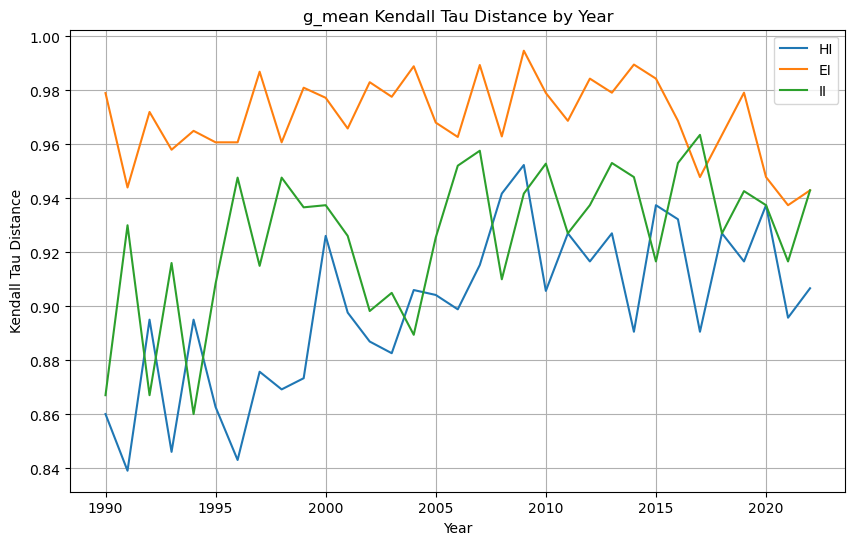

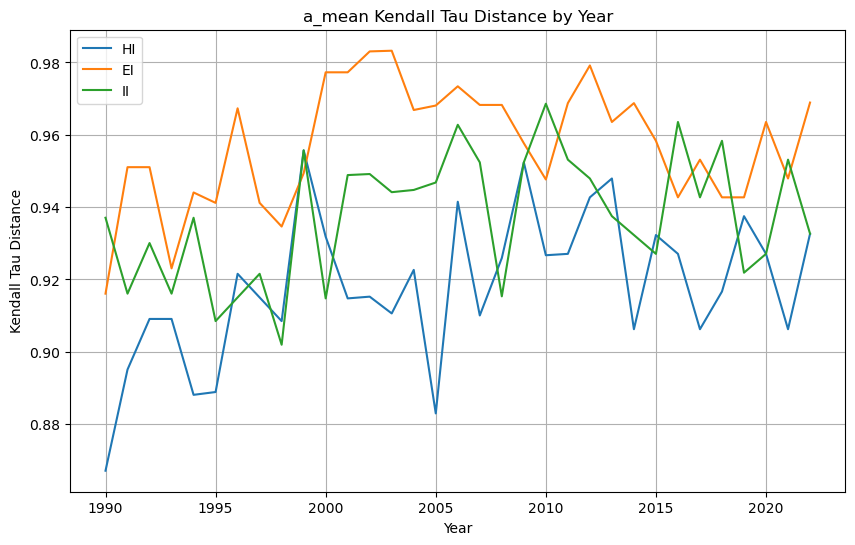

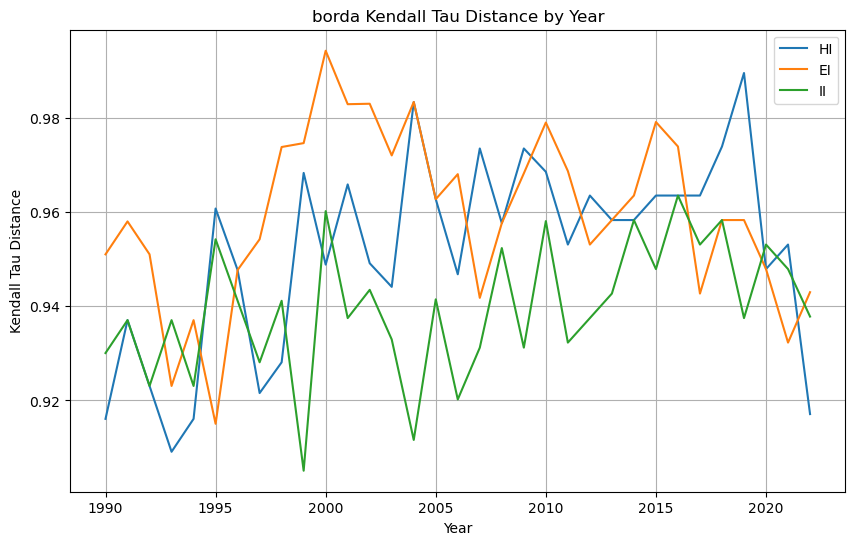

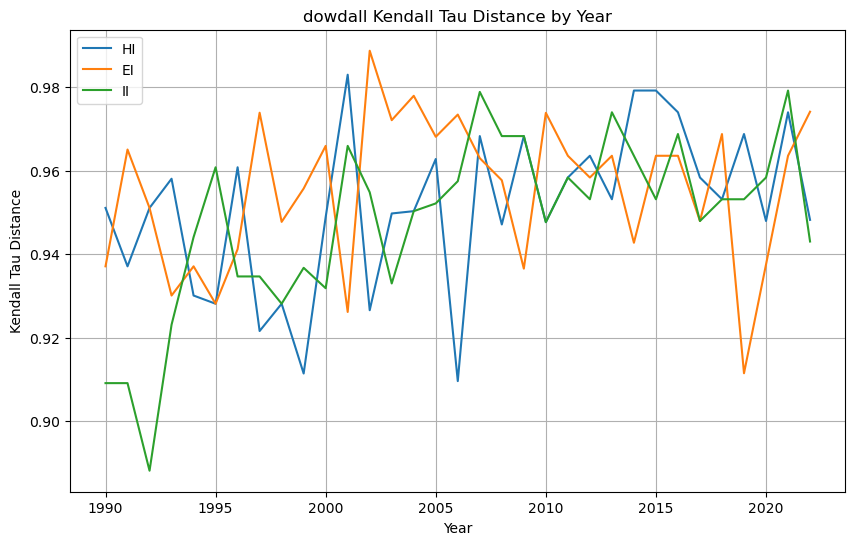

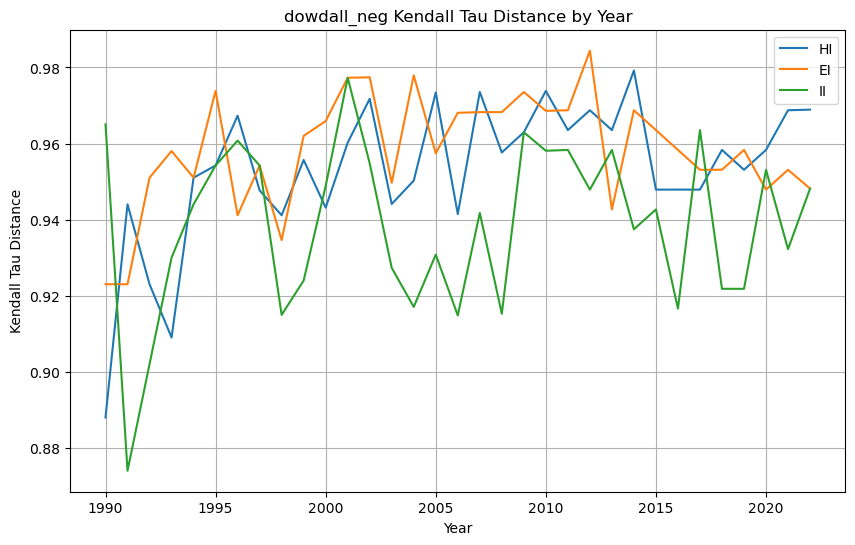

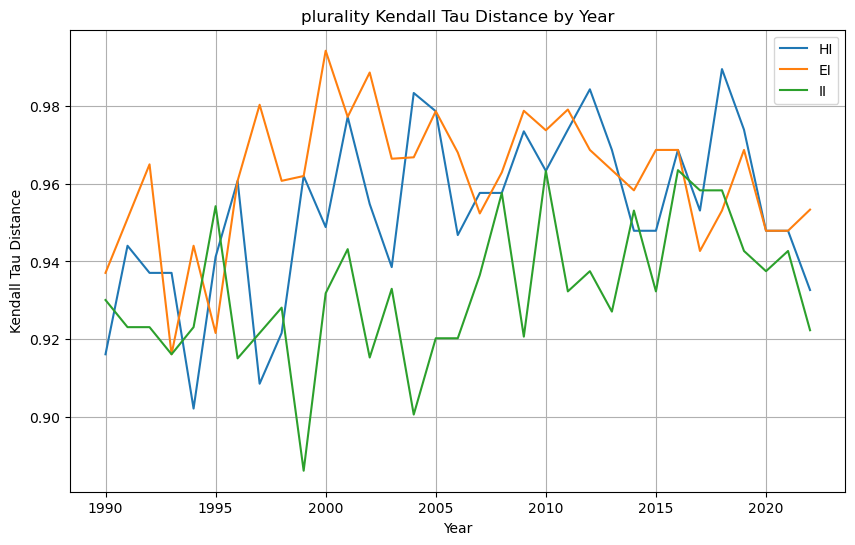

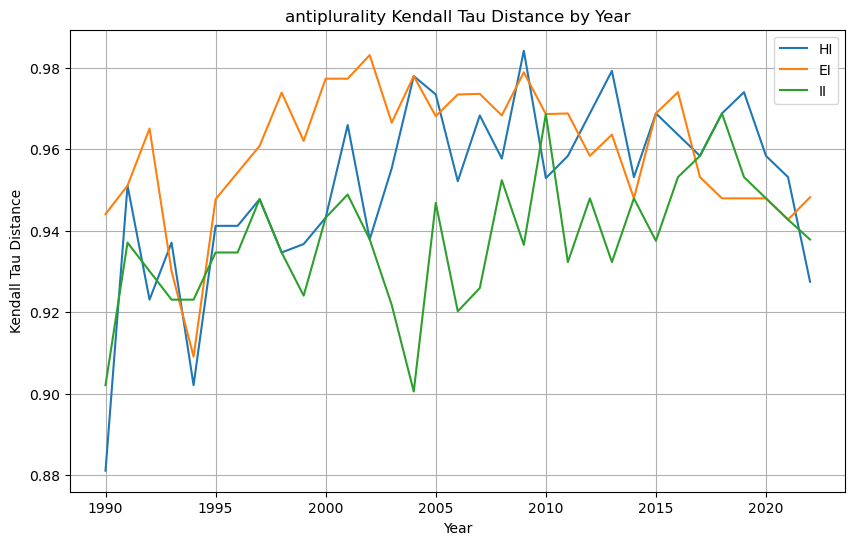

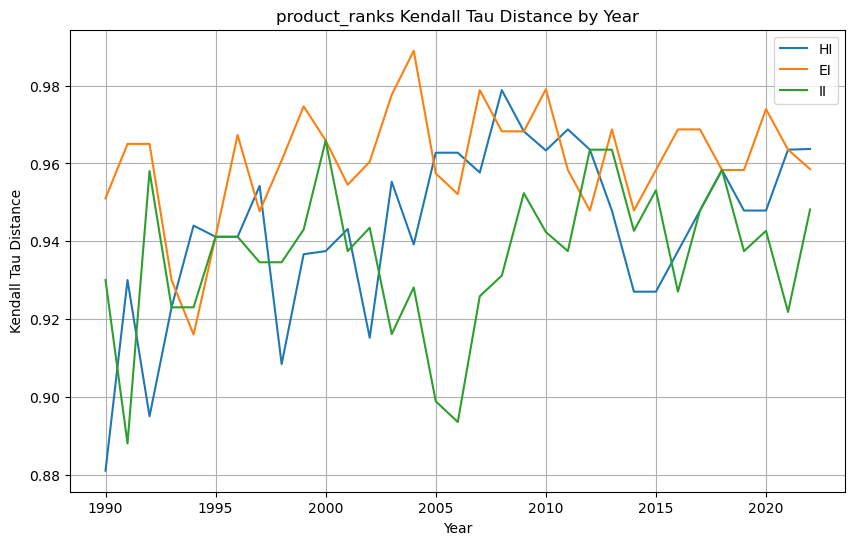

In [111]:
import pandas as pd
import matplotlib.pyplot as plt

# Фильтруем данные, оставляя только правила, кроме 'product_ranks_inverse'
filtered_data = results[results['rule'] != 'product_ranks_inverse']

# Создаем графики
for rule in filtered_data['rule'].unique():
    # Фильтруем данные по правилу
    rule_data = filtered_data[filtered_data['rule'] == rule]
    
    # Создаем новый график
    plt.figure(figsize=(10, 6))
    
    # Группируем данные по компонентам и рисуем линии для каждой компоненты
    for component in rule_data['component_excluded'].unique():
        component_data = rule_data[rule_data['component_excluded'] == component]
        plt.plot(component_data['year'], component_data['differing_pairs_proportion'], label=component)
    
    # Настройки графика
    plt.title(f'{rule} Kendall Tau Distance by Year')
    plt.xlabel('Year')
    plt.ylabel('Kendall Tau Distance')
    plt.legend()
    plt.grid(True)
    plt.show()

In [129]:
# Создание сводной таблицы
pivot_table = results.pivot_table(index=['year', 'component_excluded'], columns='rule', values='canberra_distance', aggfunc='mean')
pivot_table.loc[('Average', ''), :] = pivot_table.mean(axis=0)
pivot_table.loc[('Std Dev', ''), :] = pivot_table.std(axis=0)
# Создание LaTeX-совместимого вывода
latex_output = pivot_table.to_latex(
    na_rep='',  # Заменить отсутствующие значения пустой строкой
    multicolumn=True,  # Использовать команду multicolumn для объединения ячеек
    multicolumn_format='c',  # Формат объединенных ячеек (центрированный)
    float_format="{:.5f}".format,  # Форматирование значений как чисел с плавающей запятой с пятью знаками после запятой
    longtable=True  # Использовать longtable для многостраничной таблицы
)

# Печать LaTeX-совместимого вывода
print(latex_output)

\begin{longtable}{llrrrrrr}
\toprule
 & rule & a_mean & black & borda & dowdall & dowdall_neg & g_mean \\
year & component_excluded &  &  &  &  &  &  \\
\midrule
\endfirsthead
\toprule
 & rule & a_mean & black & borda & dowdall & dowdall_neg & g_mean \\
year & component_excluded &  &  &  &  &  &  \\
\midrule
\endhead
\midrule
\multicolumn{8}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[t]{3}{*}{1990} & EI & 8.00319 & 23.08376 & 29.80568 & 30.46455 & 29.79991 & 9.74470 \\
 & HI & 6.38560 & 27.30330 & 28.41366 & 29.61675 & 28.66167 & 6.35837 \\
 & II & 3.94170 & 24.65289 & 30.02040 & 29.82180 & 29.73269 & 4.35151 \\
\cline{1-8}
\multirow[t]{3}{*}{1991} & EI & 7.74753 & 23.16062 & 29.81036 & 30.45645 & 29.84956 & 9.38334 \\
 & HI & 6.37278 & 27.43365 & 28.48918 & 29.44003 & 28.74812 & 6.30079 \\
 & II & 3.73135 & 25.30414 & 29.89047 & 29.85640 & 29.64216 & 4.13798 \\
\cline{1-8}
\multirow[t]{3}{*}{1992} & EI & 7.54677 & 22.59494 & 29.75808 & 30.51136 

In [107]:
def condorcet(rankings):
    pairwise_counts = {}
    
    # Iterate through each pair of countries
    for i, row1 in rankings.iterrows():
        for j, row2 in rankings.iterrows():
            if i != j:  # Exclude self-comparisons
                count_i_j = (row1[rankings.columns].astype(float) > row2[rankings.columns].astype(float)).sum()
                count_j_i = (row1[rankings.columns].astype(float) < row2[rankings.columns].astype(float)).sum()
                pairwise_counts[(i, j)] = 1 if count_i_j > count_j_i else 0
    
    # Convert the dictionary to a DataFrame
    pairwise_df = pd.DataFrame(pairwise_counts.values(), index=pd.MultiIndex.from_tuples(pairwise_counts.keys())).unstack(fill_value=0)
    
    # Add country names as both row and column labels
    pairwise_df.columns = pairwise_df.columns.get_level_values(1)
    pairwise_df.index = pairwise_df.index.get_level_values(0)
    
    # Calculate total scores for each country
    scores = pairwise_df.sum(axis=1)
    return scores

0       15
1      120
2       91
3      171
4       42
      ... 
190     75
191     87
192      9
193     32
194     24
Length: 193, dtype: int64

In [106]:
HDI_forscore

HI        EI        II
0    0.659677  0.381198  0.391487
1    0.874354  0.739801  0.759811
2    0.878908  0.663134  0.709738
3    0.977723  0.742220  0.951029
4    0.645062  0.532799  0.600525
..        ...       ...       ...
190  0.786231  0.695996  0.623040
191  0.839692  0.644427  0.707458
192  0.672615  0.312986  0.363005
193  0.643123  0.548885  0.521493
194  0.606015  0.599858  0.458368

[193 rows x 3 columns]

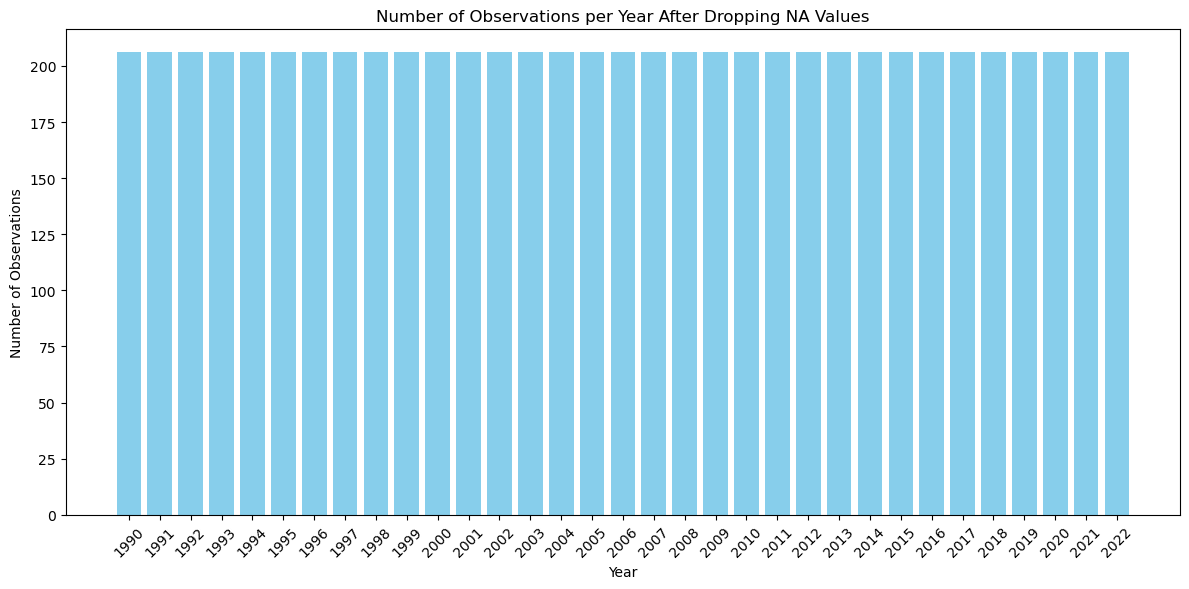

In [245]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data.csv' is your dataset file
df = hdi_all


# Create a list of years based on the columns present in the dataset
years = range(1990, 2023)

# Initialize an empty dictionary to store the number of observations per year
observations_per_year = {year: 0 for year in years}

# Loop through each year and calculate the index, then count non-NA observations
for year in years:
    # Calculate index for the year (HI, EI, II columns for the specific year)
    index_column = f'Index_{year}'
    hi_col = f'HI_{year}'
    ei_col = f'EI_{year}'
    ii_col = f'II_{year}'
    
    # Ensure the columns exist in the dataframe
    if hi_col in df.columns and ei_col in df.columns and ii_col in df.columns:
        df[index_column] = df[[hi_col, ei_col, ii_col]].mean(axis=1)
        observations_per_year[year] = df[index_column].notna().sum()

# Plotting the number of observations per year
years = list(observations_per_year.keys())
counts = list(observations_per_year.values())

plt.figure(figsize=(12, 6))
plt.bar(years, counts, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.title('Number of Observations per Year After Dropping NA Values')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()


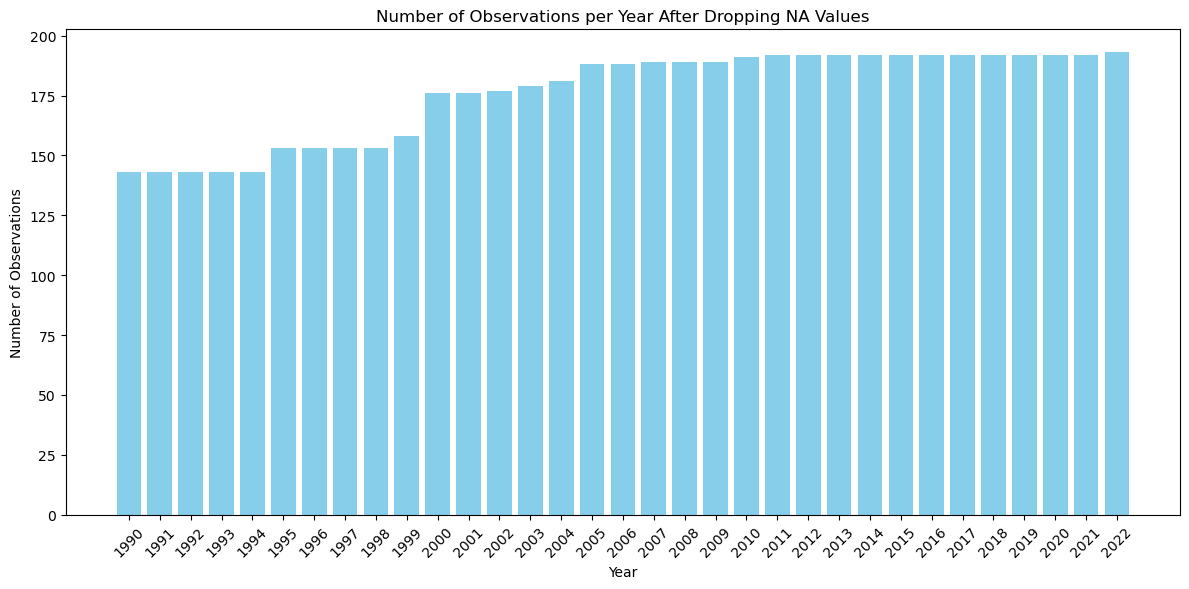

In [247]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data.csv' is your dataset file
data = hdi_all

# Initialize a dictionary to store the number of observations per year
observations_per_year = {}

# Loop through each year and process the data
for year in range(1990, 2023):
    # Create a temporary DataFrame for the current year
    HDI_year = pd.DataFrame()
    
    # Get data for the current year
    HDI_year[['HI', 'EI', 'II', 'region']] = data[['HI_{}'.format(year), 'EI_{}'.format(year), 'II_{}'.format(year), 'region']]
    
    # Remove rows with missing values
    HDI_year = HDI_year.dropna()
    
    # Store the count of observations
    observations_per_year[year] = HDI_year.shape[0]

# Convert the dictionary to a DataFrame for easier plotting
observations_df = pd.DataFrame(list(observations_per_year.items()), columns=['Year', 'Observations'])

# Plotting the number of observations per year
plt.figure(figsize=(12, 6))
plt.bar(observations_df['Year'], observations_df['Observations'], color='skyblue')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.title('Number of Observations per Year After Dropping NA Values')
plt.xticks(observations_df['Year'], rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Eliza\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


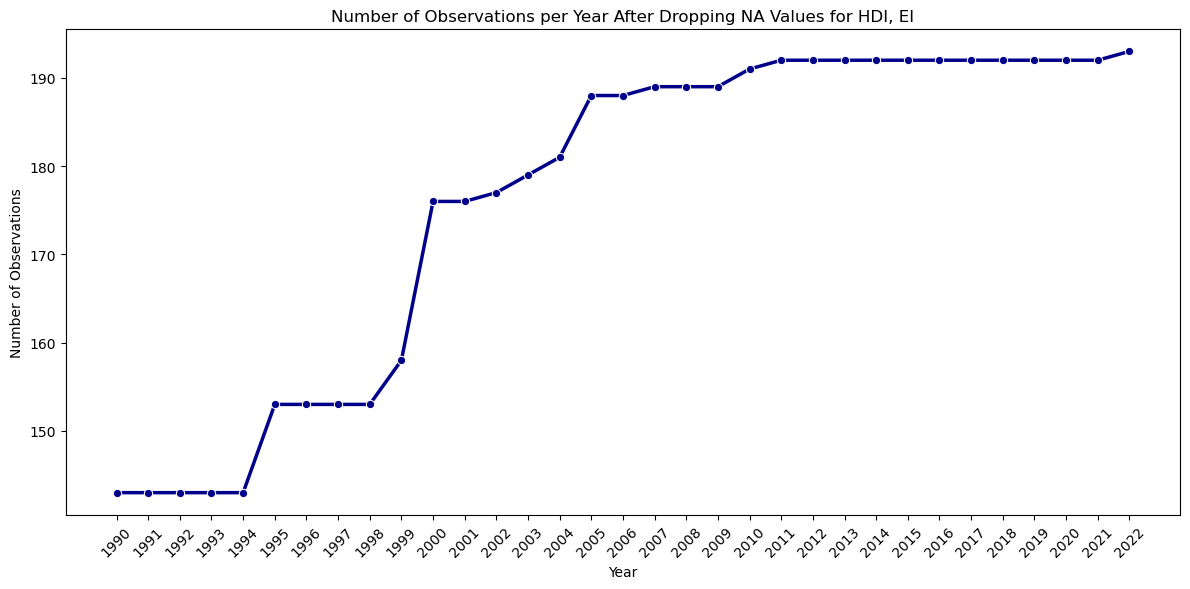

In [257]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data.csv' is your dataset file
data = hdi_all

# Initialize a dictionary to store the number of observations per year
observations_per_year = {}

# Loop through each year and process the data
for year in range(1990, 2023):
    # Create a temporary DataFrame for the current year
    HDI_year = pd.DataFrame()
    
    # Get data for the current year
    HDI_year[['HI', 'EI', 'II', 'region']] = data[['HI_{}'.format(year), 'EI_{}'.format(year), 'II_{}'.format(year), 'region']]
    
    # Remove rows with missing values
    HDI_year = HDI_year.dropna()
    
    # Store the count of observations
    observations_per_year[year] = HDI_year.shape[0]

# Convert the dictionary to a DataFrame for easier plotting
observations_df = pd.DataFrame(list(observations_per_year.items()), columns=['Year', 'Observations'])

# Plotting the number of observations per year using a line plot with Blues palette
sns.set_palette("Blues")
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Observations', data=observations_df, marker='o', linewidth=2.5, color='darkblue')
plt.xlabel('Year')
plt.ylabel('Number of Observations')
plt.title('Number of Observations per Year After Dropping NA Values for HDI, EI')
plt.xticks(observations_df['Year'], rotation=45)
plt.tight_layout()

# Save the plot as a PDF file
plt.savefig('observations_HDI.pdf')
plt.show()
